## **ABCDEats Company - Customer Segmentation**

## **Group Members:**

* **Guilherme Goudinho**- 20211552
* **Maria Inês Assunção**- 20211605
* **Osmáiny Raimundo**- e20191506
* **Vinincius Lallo**- 20211682

<a id = "toc"></a>
## Table of Contents

1. [Imports](#Imports)


### **1. Imports** <a id="Imports" class="anchor"></a>
[Back to ToC](#toc)<br>

In [1]:
#Importing the necessary libraries for our analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from math import ceil
from PIL import Image
from IPython.display import display
from matplotlib.animation import Animation #For the sequential HR graphs
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation #For the sequential HR graphs
from scipy.stats import chi2_contingency
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from itertools import product
import warnings
warnings.filterwarnings("ignore")
from ydata_profiling import ProfileReport
%config InlineBackend.figure_format = 'retina' # for better resolution plots
sns.set()
pd.set_option('display.max_columns', None) # to see all the columns

In [2]:
# Auxiliary Function to Calculate bins for histograms based on Sturges' rule
def number_bins_sturges(data):
    '''
    Calculates the number of bins based on the number of data points, using Sturges' rule
    Sturges' rule: k = log2(n) + 1

    Requires: The dataset for which the number of bins is to be calculated.
    Ensures: 
        - The returned value is a positive integer representing the number of bins.
        - The number of bins increases logarithmically as the dataset size increases.
    '''
    
    n = len(data)
    bins = np.ceil(np.log2(n) + 1) # np.log2 computes the base-2 logarithm of n, and np.ceil rounds the result up to the next whole number.
    return int(bins)

#Defining the colors for our graphs
colors = {
    "R": "#F5979D", #light red
    "BL": "#0a9ea3", #cyan blue
    "BR": "#4F323D", #brown
    "B": "#9cc5d9",  #light blue
    "G": "#099c52",  #spring green
    "Y": "#d69231",   #Yellow
    "M": "#960b50",   # some kind of pink
    "P": "#6947ad" ,   # Purple
    "PR": "#ad474c"  #Weird red
}

def show_missing(data):
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    for item in data.columns:
        variables.append(item)
        dtypes.append(data[item].dtype)
        count.append(len(data[item]))
        unique.append(len(data[item].unique()))
        missing.append(data[item].isna().sum())
    output = pd.DataFrame({
    'variable': variables, 
    'dtype': dtypes,
    'count': count,
    'unique': unique,
    'missing': missing, 
    })
    return output

### **2. Loading our Dataset**

In [3]:
food_df=pd.read_csv("food_df_dataset.csv") # Importing our dataset into a variable "food_df" with imputed missing values

__**Setting our Index Column**__

In [4]:
food_df = food_df.set_index('customer_id')

In [5]:
food_df['customer_region'].dtype

dtype('int64')

> This is wrong, probably as a consequence of the data exporting, so we need to turn <code>customer_region</code> back into 'object'.

In [6]:
food_df['customer_region'] = food_df['customer_region'].astype('object') # fixed

> We imputed our <b>Missing Values</b> in the previous notebook and exported the dataset with these treated.
> - <code>customer_age</code>: Imputed with the mean. (After conducting analysis)
> - <code>first_order</code>: Imputed with '0' as these corresponded to customers whose first_order was on the same day as last_order (day 0).
> - <code>HR_0</code>: Imputed with the discrepancy between total_order by DOW and by HR.

In [7]:
columns_with_missing = food_df.isna().sum()[food_df.isna().sum() > 0].count()
print(f"There are {columns_with_missing} columns with more than 0 missing values.")

There are 0 columns with more than 0 missing values.


In [8]:
food_df.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method',
       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
       'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
       'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes',
       'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'DOW_0', 'DOW_1',
       'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HR_0', 'HR_1', 'HR_2',
       'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10',
       'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18',
       'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'total_orders',
       'midday_orders', 'evening_orders', 'late_night_orders', 'Weekend',
       'Weekday', 'Western_Cuisine', 'Asian_Cuisine', 'Desserts_Beverages',
       'total_spent'],
      dtype='object')

### **3. Separating Our Data**

> We will drop the following columns as they were previously engineered to be represented by aggregations, described in our EDA and initial preprocessing notebook (part 1).
> We will considered the aggregations for our analysis, since studying outliers in them will necessarily give us insights into the individual divisions. 
> - For example, <code>DOW_[0-6]</code> into 'Weekday' or 'Weekend. 
> - <code>CUI's</code> into Asian, Western, Desserts_Beverages, Healthy, OTHER, streetfood/snacks.

In [9]:
columns_to_drop = ['DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 
                   'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 
                   'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 
                   'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20', 'HR_21', 
                   'HR_22', 'HR_23',
                   'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe', 
                   'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 
                   'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes', 
                   'CUI_Thai']
food_df = food_df.drop(columns=columns_to_drop)
show_missing(food_df)

variable    dtype  count  unique  missing
0            customer_region   object  31737       3        0
1               customer_age    int64  31737      66        0
2               vendor_count    int64  31737      36        0
3              product_count    int64  31737      92        0
4                   is_chain    int64  31737      60        0
5                first_order    int64  31737      91        0
6                 last_order    int64  31737      91        0
7                 last_promo   object  31737       4        0
8             payment_method   object  31737       3        0
9                CUI_Healthy  float64  31737    1285        0
10                 CUI_OTHER  float64  31737    2756        0
11  CUI_Street Food / Snacks  float64  31737    2554        0
12              total_orders    int64  31737      71        0
13             midday_orders    int64  31737      46        0
14            evening_orders    int64  31737      44        0
15         late_night_orders    int64  31737      55        0
16                   Weekend    int64  31737      38        0
17                   Weekday    int64  31737      47        0
18           Western_Cuisine  float64  31737    4713        0
19             Asian_Cuisine  float64  31737    6757        0
20        Desserts_Beverages  float64  31737    3029        0
21               total_spent  float64  31737   10746        0

> After conducting our analysis on the box plots for each of our numerical variables, we concluded that our one-time customers were probably creating a bias in our data. <br>
> For this reason, we decided to separate this type of customer and perform a separate analysis. The rest of our data will represent the behavior of the customers we are trying to segment.<br>
> We believe this will highly influence our outlier percentages, lowering them and allow us to retain as much information as possible. <br>

> This notebook will address the <b>Remaining Customers</b>.

In [10]:
one_time_customers_df = food_df[food_df['total_orders'] == 1]
food_df = food_df[food_df['total_orders'] > 1]
print(f"One-time customers: {one_time_customers_df.shape[0]} records")
print(f"Remaining customers: {food_df.shape[0]} records")

One-time customers: 6908 records
Remaining customers: 24829 records


> We identified <b>24829</b> records where we might be able to identify patterns/trends in our customers behavior. <br>
> These represent roughly <b>78%</b> of our data. <br>

### **Remaining Customers**

In [11]:
show_missing(food_df)

variable    dtype  count  unique  missing
0            customer_region   object  24829       3        0
1               customer_age    int64  24829      65        0
2               vendor_count    int64  24829      36        0
3              product_count    int64  24829      91        0
4                   is_chain    int64  24829      60        0
5                first_order    int64  24829      90        0
6                 last_order    int64  24829      91        0
7                 last_promo   object  24829       4        0
8             payment_method   object  24829       3        0
9                CUI_Healthy  float64  24829    1227        0
10                 CUI_OTHER  float64  24829    2678        0
11  CUI_Street Food / Snacks  float64  24829    2318        0
12              total_orders    int64  24829      70        0
13             midday_orders    int64  24829      46        0
14            evening_orders    int64  24829      44        0
15         late_night_orders    int64  24829      55        0
16                   Weekend    int64  24829      38        0
17                   Weekday    int64  24829      47        0
18           Western_Cuisine  float64  24829    4668        0
19             Asian_Cuisine  float64  24829    6650        0
20        Desserts_Beverages  float64  24829    2932        0
21               total_spent  float64  24829   10405        0

__**Data Statistics for Remaining Customers**__

In [12]:
food_df.describe().round(2)

customer_age  vendor_count  product_count  is_chain  first_order  \
count      24829.00      24829.00       24829.00  24829.00     24829.00   
mean          27.52          3.70           6.89      3.45        23.35   
std            7.07          2.87           7.43      4.29        20.82   
min           15.00          1.00           2.00      0.00         0.00   
25%           23.00          2.00           3.00      1.00         6.00   
50%           26.00          3.00           4.00      2.00        18.00   
75%           31.00          4.00           8.00      4.00        36.00   
max           80.00         41.00         269.00     83.00        89.00   

       last_order  CUI_Healthy  CUI_OTHER  CUI_Street Food / Snacks  \
count    24829.00     24829.00   24829.00                  24829.00   
mean        68.65         1.15       3.60                      4.37   
std         19.53         6.50      10.82                     16.93   
min          0.00         0.00       0.00                      0.00   
25%         58.00         0.00       0.00                      0.00   
50%         75.00         0.00       0.00                      0.00   
75%         84.00         0.00       1.46                      0.00   
max         90.00       255.81     366.08                    454.45   

       total_orders  midday_orders  evening_orders  late_night_orders  \
count      24829.00       24829.00        24829.00           24829.00   
mean           5.33           2.35            2.22               1.04   
std            5.39           3.25            3.19               3.06   
min            2.00           0.00            0.00               0.00   
25%            2.00           1.00            0.00               0.00   
50%            4.00           2.00            1.00               0.00   
75%            6.00           3.00            3.00               1.00   
max           94.00          71.00           61.00              81.00   

        Weekend   Weekday  Western_Cuisine  Asian_Cuisine  Desserts_Beverages  \
count  24829.00  24829.00         24829.00       24829.00            24829.00   
mean       2.46      2.87            10.62          20.76                4.71   
std        2.69      3.41            18.91          32.76               13.22   
min        0.00      0.00             0.00           0.00                0.00   
25%        1.00      1.00             0.00           0.00                0.00   
50%        2.00      2.00             4.18          11.49                0.00   
75%        3.00      3.00            13.32          26.18                3.51   
max       45.00     60.00           468.33        1201.27              326.10   

       total_spent  
count     24829.00  
mean         45.22  
std          50.13  
min           1.78  
25%          17.54  
50%          30.09  
75%          54.77  
max        1418.33

> - The average <code>customer_age</code> is still 27y.
> - On average, people buy from 3.12 different vendors.
> - Each customer, on average, makes 4.39 orders and 5.69 products.
> - 50% of customers made their <code>first_order</code> within the first month and their <code>last_order</code> within the third.
> - Amounts spent by <code>CUI Aggregations</code> differ a lot, from 0.95€ to 17.65€.
> - Customers spent the most on <code>Asian_Cuisine</code> followed by <code>Western_Cuisine</code>, with 17.65€ and 8.92€ respectively.
> - There are more orders during the midday or the evening. Also, on average, more orders are placed during the week.
> - On average, customers spend 38.46€ ordering food. The max for <code>total_spent</code> is 1418.33€ which is surprising.

### **4. Treating Outliers**

> In this section, we will discuss the most appropriate outlier treatment for each column.

In [13]:
num_columns = food_df.select_dtypes(include=['int64', 'float64']).columns # numerical variables
cat_columns = food_df.select_dtypes(include=['object', 'O']).columns # categorical variables

__**Calculating the Percentage of Outliers per Column**__ (Inter-Quartile Range Formula)

$IQR = Q_3 – Q_1$

<br>

---

<br>

**Outliers** are the observations that fall:
- below $Q_1 − 1.5 \times IQR$

or

- above $Q_3 + 1.5 \times IQR$

<br>

In [14]:
outlier_percentages = {}

# We know that low outliers are below Q 1 − 1.5 ⋅ IQR ‍ and high outliers are above Q 3 + 1.5 ⋅ IQR 
for column in num_columns:
        #Defining Q1 and Q3 to then find IQR 
        Q1 = food_df[column].quantile(0.25)
        Q3 = food_df[column].quantile(0.75)
        IQR = Q3 - Q1
        #Getting the outliers below the first quantile and above the second quantile
        outliers = food_df[(food_df[column] < (Q1 - 1.5 * IQR)) | (food_df[column] > (Q3 + 1.5 * IQR))]
        #Getting the percentage of the outliers
        percentage_outliers = (len(outliers) / len(food_df)) * 100
        outlier_percentages[column] = percentage_outliers

#Printing the results and counting the number of columns per the percentage higher or lower than 5.
nr_col_lower_5=0
nr_col_higher_5=0
print("Percentage of outliers per column using IQR:")
for column, percentage in outlier_percentages.items():
    print(f"{column}: \033[1;35m{percentage:.2f}%\033[0m")
    if percentage <5:
        nr_col_lower_5+=1
    if percentage >5:
        nr_col_higher_5+=1

#Printing the number of columns who have a percentage lower than 5% and then higher than 5%. 
# We chose 5% because it was the percentage advised during classes
print(f"From the columns, \033[1;33m{nr_col_lower_5}\033[0m have a percentage lower than 5%")
print(f"From the columns, \033[1;33m{nr_col_higher_5}\033[0m have a percentage higher than 5%")

Percentage of outliers per column using IQR:
customer_age: 3.40%
vendor_count: 8.53%
product_count: 8.35%
is_chain: 7.95%
first_order: 0.79%
last_order: 2.36%
CUI_Healthy: 8.16%
CUI_OTHER: 21.29%
CUI_Street Food / Snacks: 14.70%
total_orders: 7.27%
midday_orders: 7.24%
evening_orders: 5.47%
late_night_orders: 11.26%
Weekend: 6.24%
Weekday: 9.28%
Western_Cuisine: 7.86%
Asian_Cuisine: 6.89%
Desserts_Beverages: 15.87%
total_spent: 7.54%
From the columns, 3 have a percentage lower than 5%
From the columns, 16 have a percentage higher than 5%


> - We decided to consider a <b>threshold of 5%</b>, where outliers with a percentage lower than 5% will be completly removed. Meaning we will save them to a variable and decide how to analyse them later. <br>
> - Outliers above 5%, we will get the extreme outliers by a handmade function and winsorize the rest of them to the upper limit.<br>
> - Outliers in the CUI columns will not be removed because they are represent relevant data. We believe that because there are so many types of cuisines, the ones that are less popular will have a lot of '0' values and this is causing the real data to look like outliers.

__**Ploting Box Plots**__

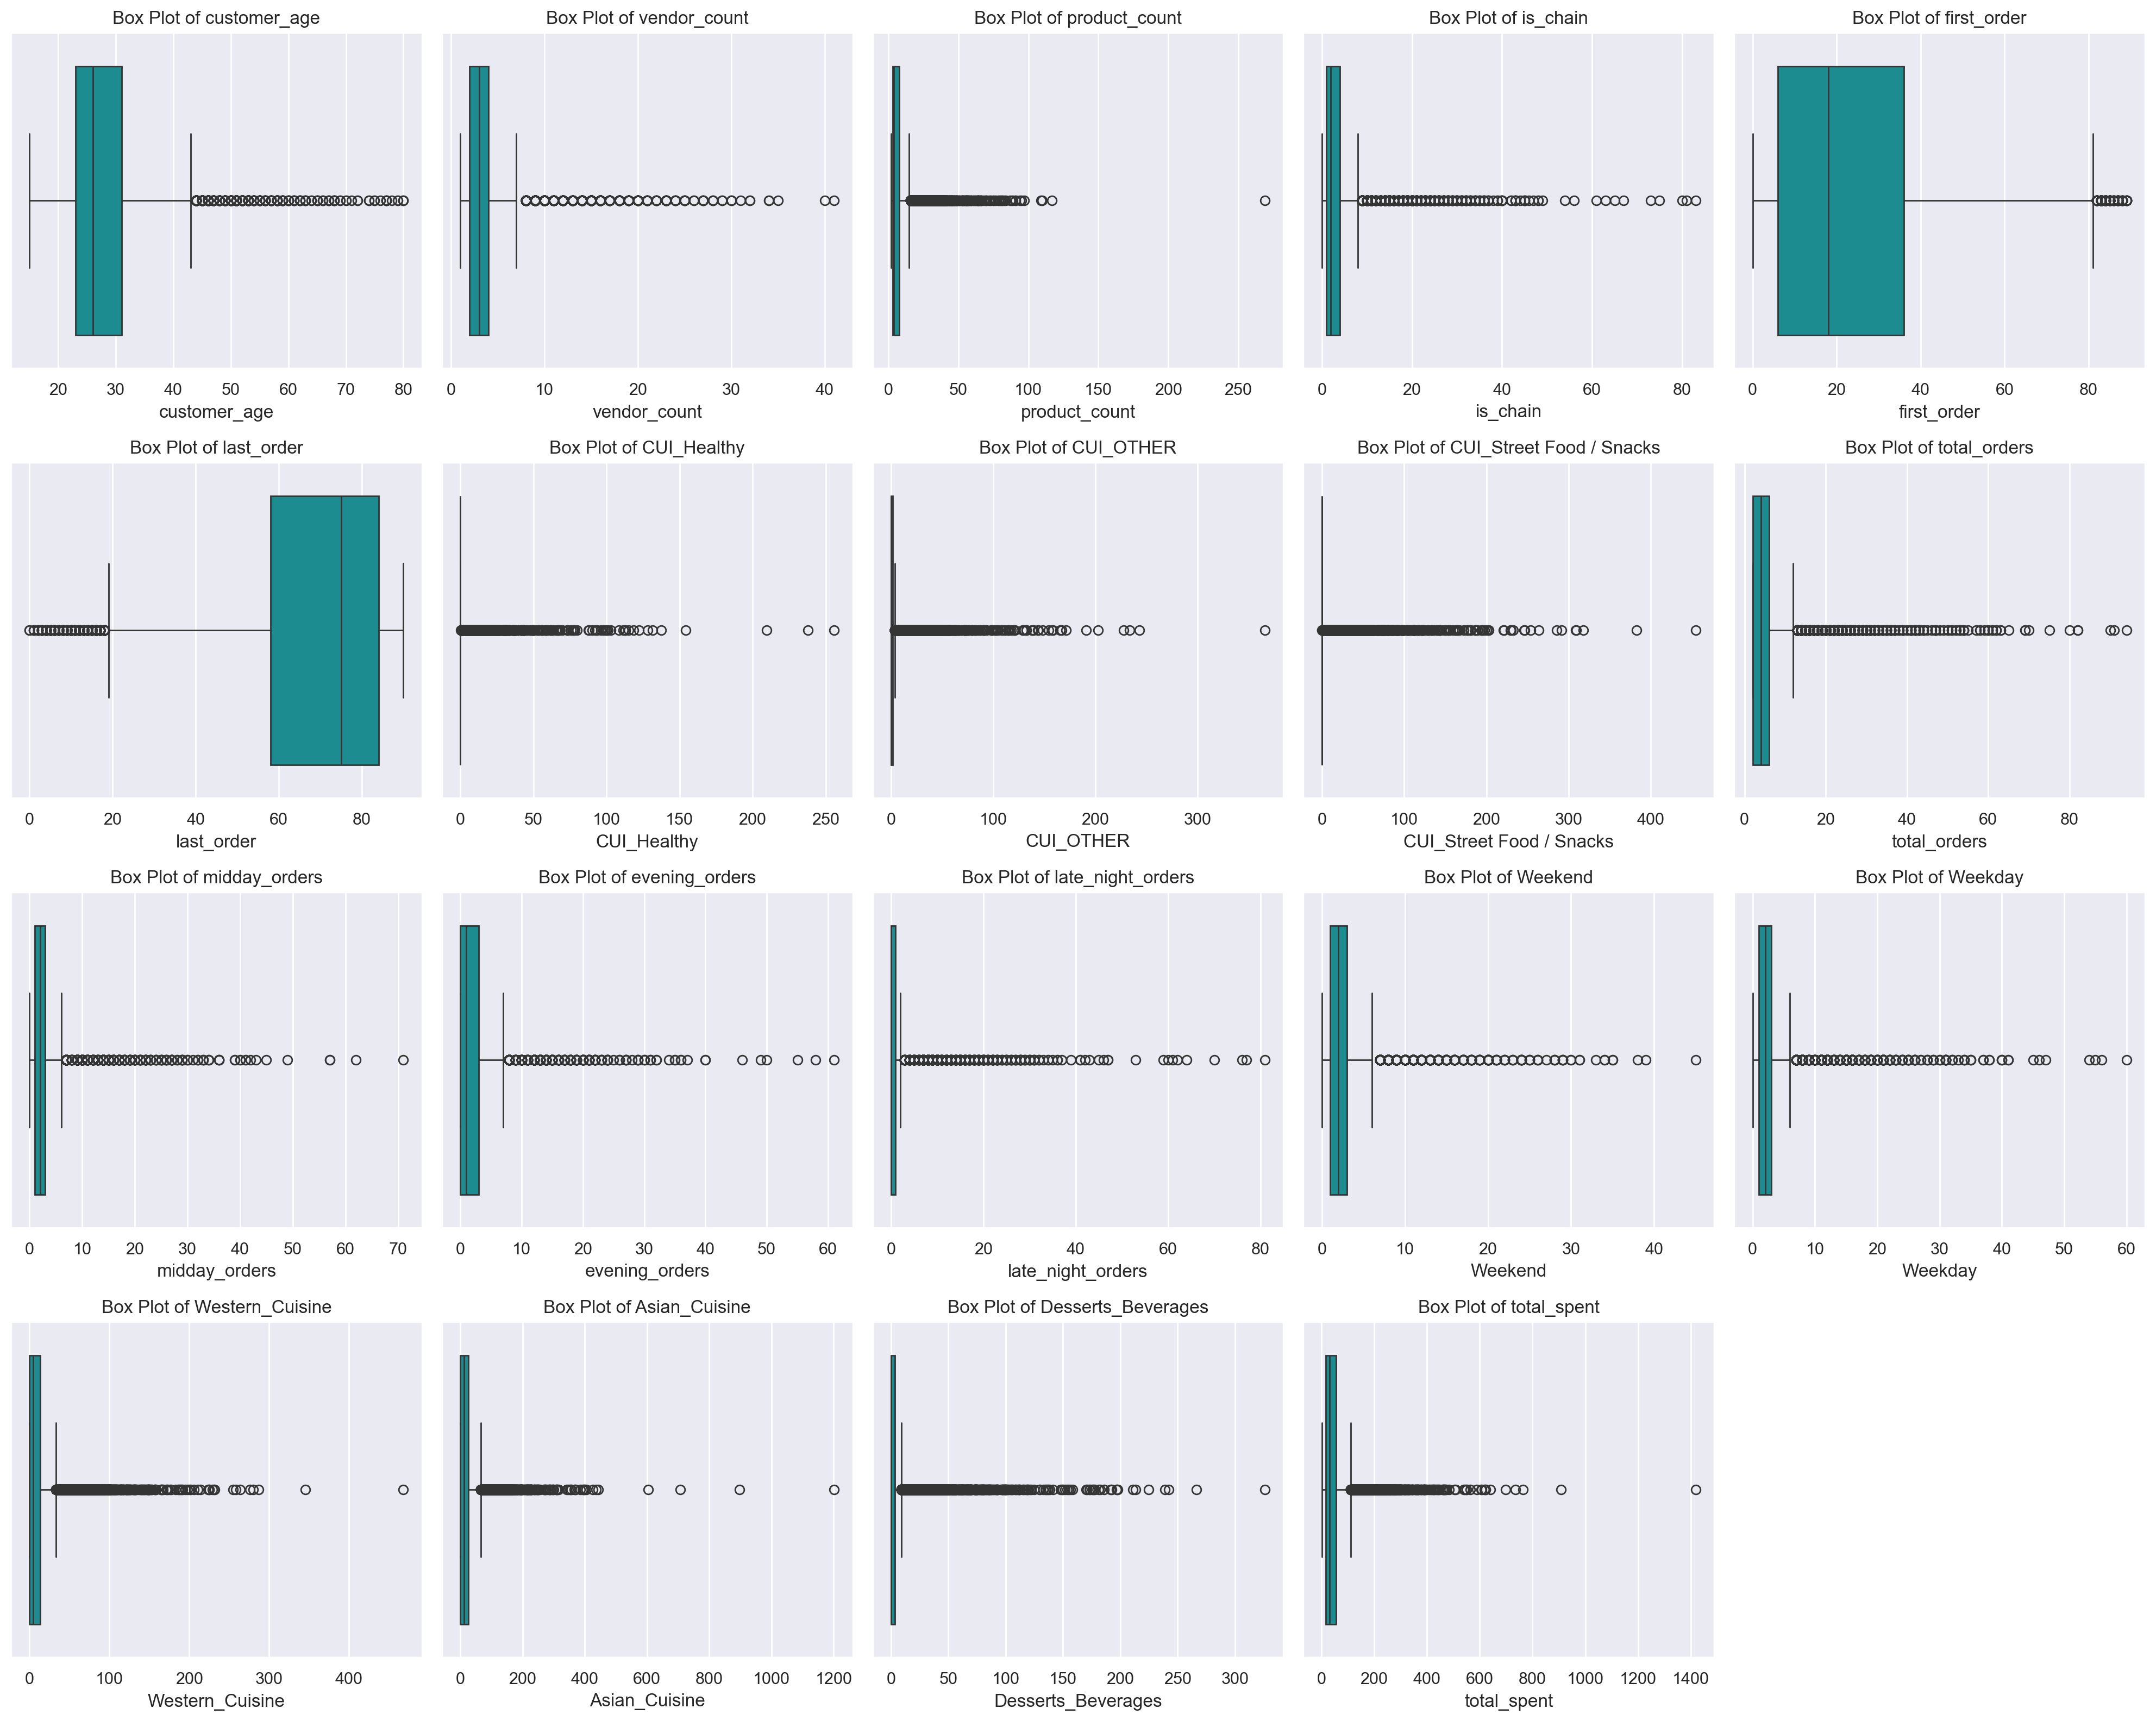

In [15]:
n_cols = 5
n_rows = 4  # Calculate rows needed

# Set the figure size for readability
plt.figure(figsize=(20, 4 * n_rows))

# Plot each numerical column in a separate horizontal box plot
for i, column in enumerate(num_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=food_df, x=column, color = colors['BL'])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()

In [16]:
# Function to automate outlier removal by the Interquartile Range
lower_limit = 0
upper_limit = 0
def outlier_removal_helper(dataframe, feature, lower_limit=lower_limit, upper_limit = upper_limit):
    # Mask to filter values within the IQR range
    mask = dataframe[feature].between(lower_limit, upper_limit, inclusive="both")
     
    return dataframe[mask]

# Function to automate lower and upper bound detection in a feature to facilitate plotting box plots
def boxplt_info(feature,dataframe=food_df):
    Q1 = dataframe[feature].quantile(0.25)
    Q3 = dataframe[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    return lower_limit, ceil(upper_limit)

# Auxiliary function to check the percetnage of data kept
def outliers_left(df1, df2):
    return print (f" The percentage of data kept is: {round((len(df1) / len(df2) ) * 100,2)}")

__**Checking Features with <5% Outliers**__

> This section will work as follows:
> - Select feature, <i>'feature_name'</i> (that have outliers <5%)
> - Plot boxplot
> - Calculate upper and lower limits (save values)
> - Saving outliers into a variable <i>'out_feature_name'</i>
> - Checking the describe of that variable to identify trends or patterns
> - Removing the outliers from the auxiliary dataset <b>'food_df_out'</b>
> - Print percentage of data left (checking how much information we keep)<br>

> At the end we will plot all boxplots again (to check if outliers were dropped sucessfully) and the total percentage of data left, to check if we are not losing relevant information.

In [17]:
food_df_out = food_df.copy() # creating a copy of our data set to facilitate pipeline

    customer_age

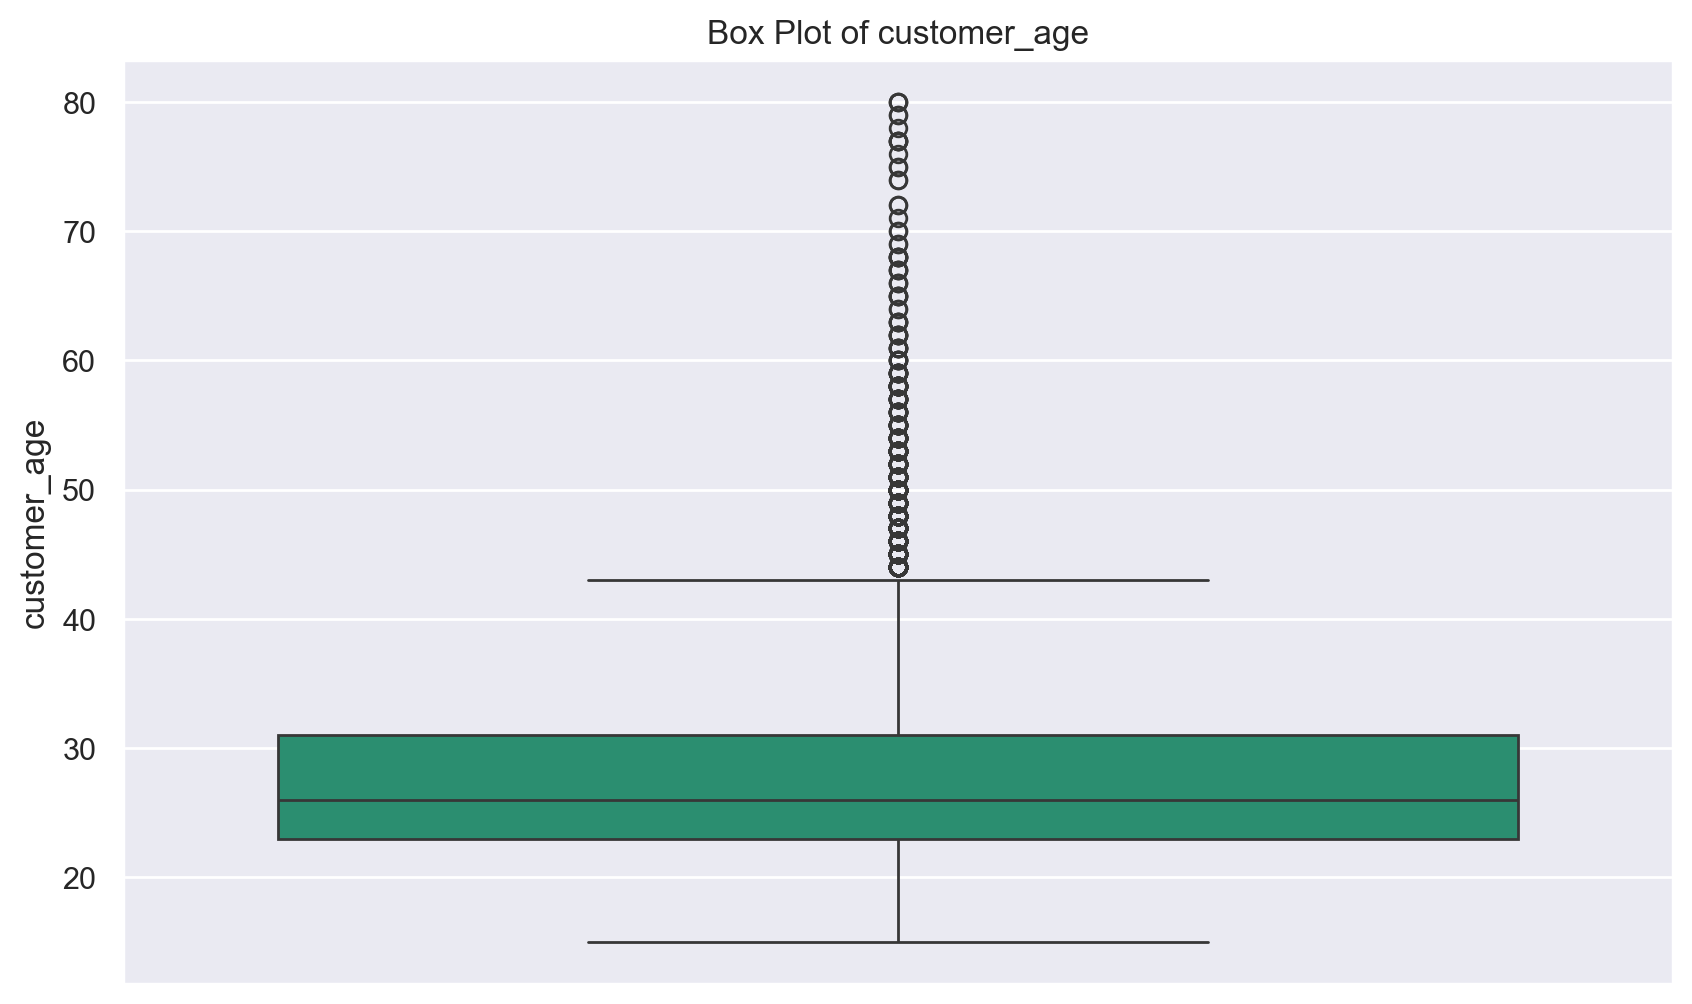

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=food_df, y='customer_age', palette='Dark2')
plt.title('Box Plot of customer_age')
plt.ylabel('customer_age')
plt.show()

In [19]:
lower_limit, upper_limit = boxplt_info('customer_age')
print(f" The lower limit is {lower_limit}, and the upper limit is {upper_limit}")

 The lower limit is 11.0, and the upper limit is 43


In [20]:
out_customer_age = food_df[food_df['customer_age'] > upper_limit] # saving outliers
out_customer_age['customer_age'].describe(include=all).round(2)

count    845.00
mean      50.05
std        6.66
min       44.00
25%       45.00
50%       48.00
75%       53.00
max       80.00
Name: customer_age, dtype: float64

> - The were 845 outliers identified.
> - The average value of the outliers removed is 50.05.
> - 50% of the outliers are below the value 48.
> - The lowest outlier has value 44 and the highest has value 80.

> However, because we have checked before that <code>customer_age</code> isn't correlated with any other variable, we will probably end up dropping it. <br>
> For this reason, we have decided not to remove any outliers.

In [21]:
outliers_left(food_df_out, food_df)

 The percentage of data kept is: 100.0


    first_order

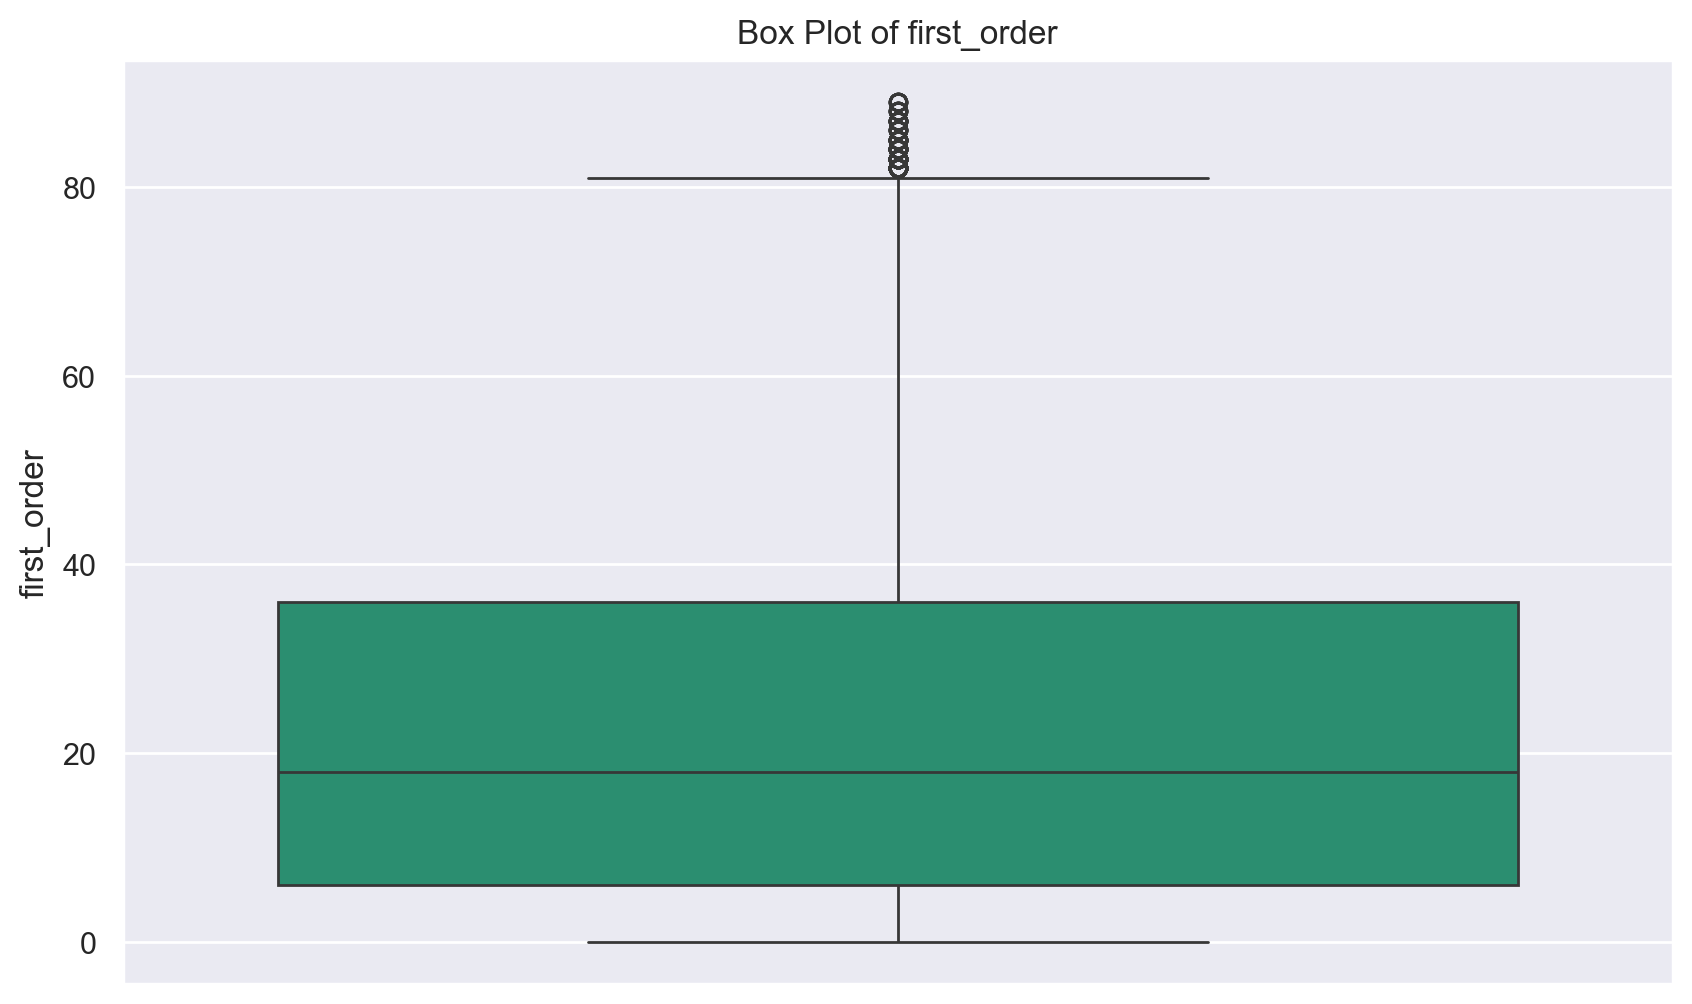

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=food_df_out, y='first_order', palette='Dark2')
plt.title('Box Plot of first_order')
plt.ylabel('first_order')
plt.show()

In [23]:
lower_limit, upper_limit= boxplt_info('first_order')
print(f" The lower limit is {lower_limit}, and the upper limit is {upper_limit}")

 The lower limit is -39.0, and the upper limit is 81


In [24]:
out_first_order = food_df[food_df['first_order'] > upper_limit] # saving outliers
out_first_order['first_order'].describe().round(2)

count    196.00
mean      84.09
std        2.05
min       82.00
25%       82.00
50%       83.00
75%       85.00
max       89.00
Name: first_order, dtype: float64

> - The were 196 outliers identified.
> - The average value of the outliers removed is 84.09.
> - 50% of the outliers are below the value 83.
> - The lowest outlier has value 82 and the highest has value 89.

In [25]:
food_df_out = outlier_removal_helper(food_df_out,'first_order', lower_limit, upper_limit) # removing them our auxiliary data set
outliers_left(food_df_out, food_df)

 The percentage of data kept is: 99.21


    last_order

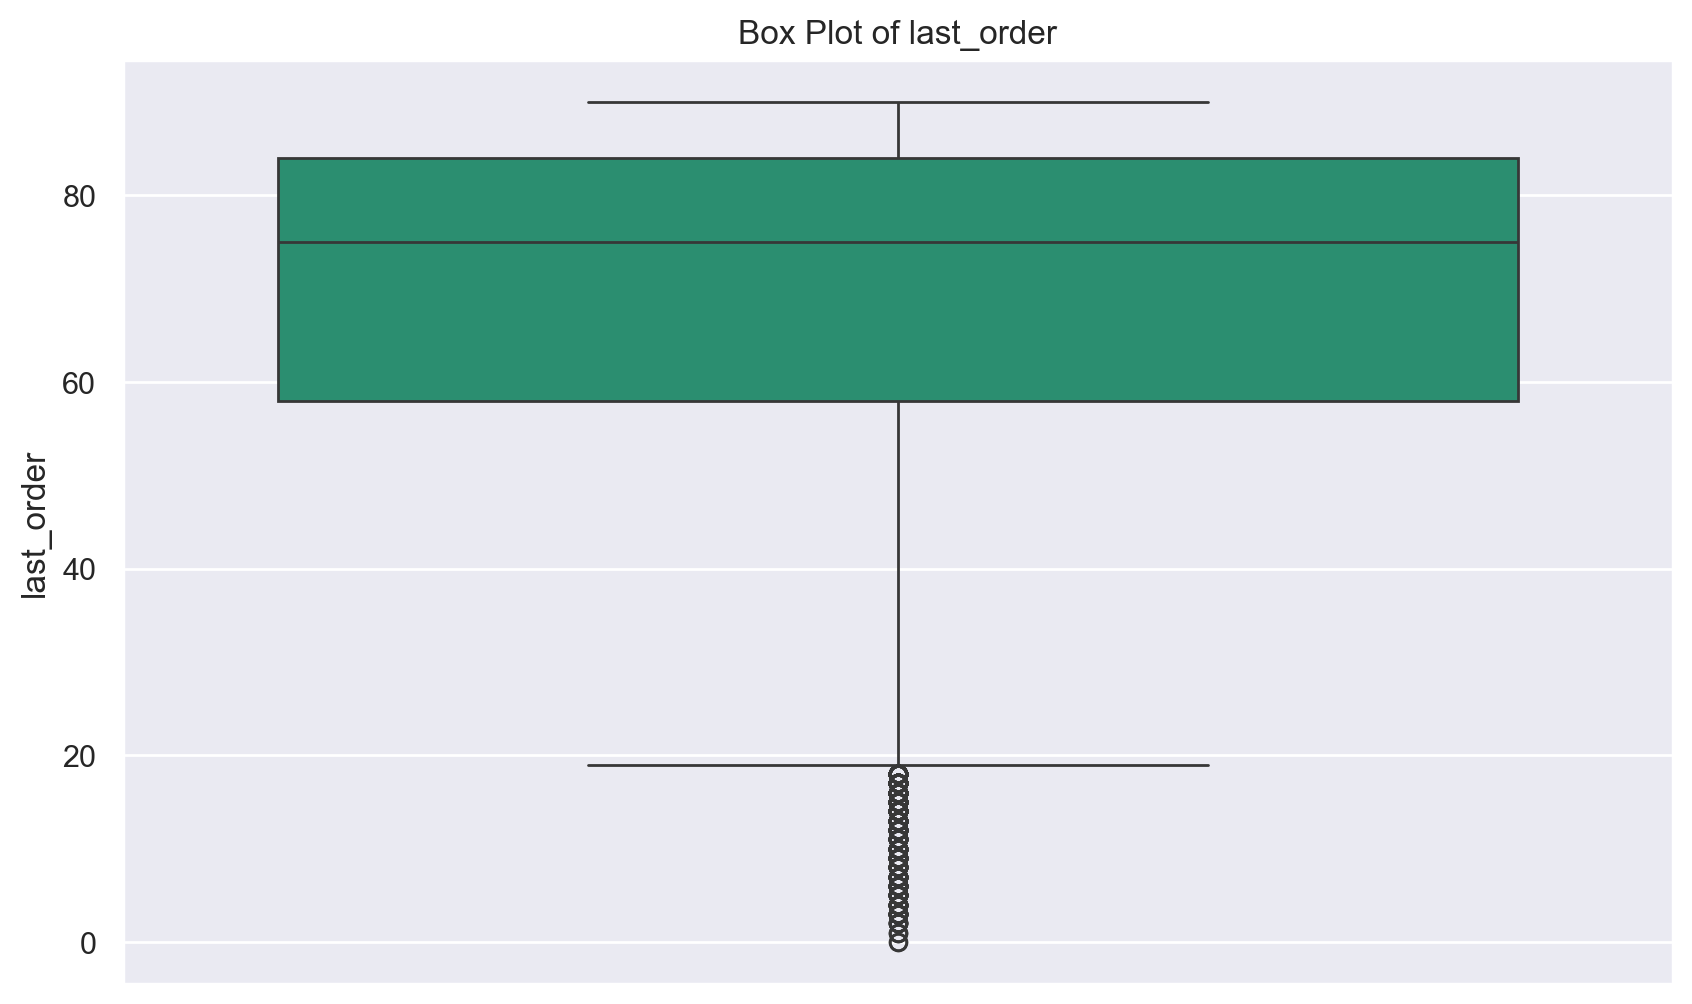

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=food_df_out, y='last_order', palette='Dark2')
plt.title('Box Plot of last_order')
plt.ylabel('last_order')
plt.show()

In [27]:
lower_limit, upper_limit= boxplt_info('last_order')
print(f" The lower limit is {lower_limit}, and the upper limit is {upper_limit}")

 The lower limit is 19.0, and the upper limit is 123


In [28]:
out_last_order = food_df[food_df['last_order'] < lower_limit] # saving outliers
out_last_order['last_order'].describe().round(2)

count    587.00
mean      11.85
std        4.67
min        0.00
25%        8.00
50%       13.00
75%       16.00
max       18.00
Name: last_order, dtype: float64

> - The were 587 outliers identified.
> - The average value of the outliers removed is 11.85.
> - 50% of the outliers are below the value 13.
> - The lowest outlier has value 0 and the highest has value 18.

In [29]:
print(f"The dataset had {out_last_order.shape[0]} outliers.")
print(f"Considering previous iterations, there are only {food_df_out[food_df_out['last_order'] < lower_limit].shape[0]} outliers left.")

The dataset had 587 outliers.
Considering previous iterations, there are only 587 outliers left.


In [30]:
food_df_out = outlier_removal_helper(food_df_out,'last_order', lower_limit, upper_limit) # removing them our auxiliary data set
outliers_left(food_df_out, food_df)

 The percentage of data kept is: 96.85


__**Checking Features with Outliers Between 5%-10%**__

> This section will work as the previous one, except:
> - We want to preserve as much information as possible, so we will use visual tools and manual outlier detection techniques to make our decisions.
> - We will use the IQR Formula with limits times 3 (instead of 1.5), this will increase our range and allow us to identify extreme outliers, guiding our approach.

In [31]:
extreme_lower_limit = 0
extreme_upper_limit = 0
# Function to help remove extreme outliers 
def extreme_outliers_removal(dataframe, feature,extreme_lower_limit= extreme_lower_limit, extreme_upper_limit=extreme_upper_limit):
    
    # Mask to filter values within the IQR range
    dataframe = dataframe[(dataframe[feature] >= extreme_lower_limit) & (dataframe[feature] <= extreme_upper_limit)]

    return dataframe

In [32]:
# Function to get the extreme upper and lower bounds
def boxplt_info_eo(feature, dataframe=food_df):
    Q1 = dataframe[feature].quantile(0.25)
    Q3 = dataframe[feature].quantile(0.75)
    IQR = Q3 - Q1
    extreme_lower_limit = Q1 - 3 * IQR
    extreme_upper_limit = Q3 + 3 * IQR

    return extreme_lower_limit, ceil(extreme_upper_limit)

    is_chain

> At this point, we have decided not to treat the outliers for <code>is_chain</code> as we want to categorize this feature and transform it into a categorical variable with the percentages of orders made in chain restaurants. <br>
> We believe this categorization will provide us valuable insights into our customers behavior.

    product_count

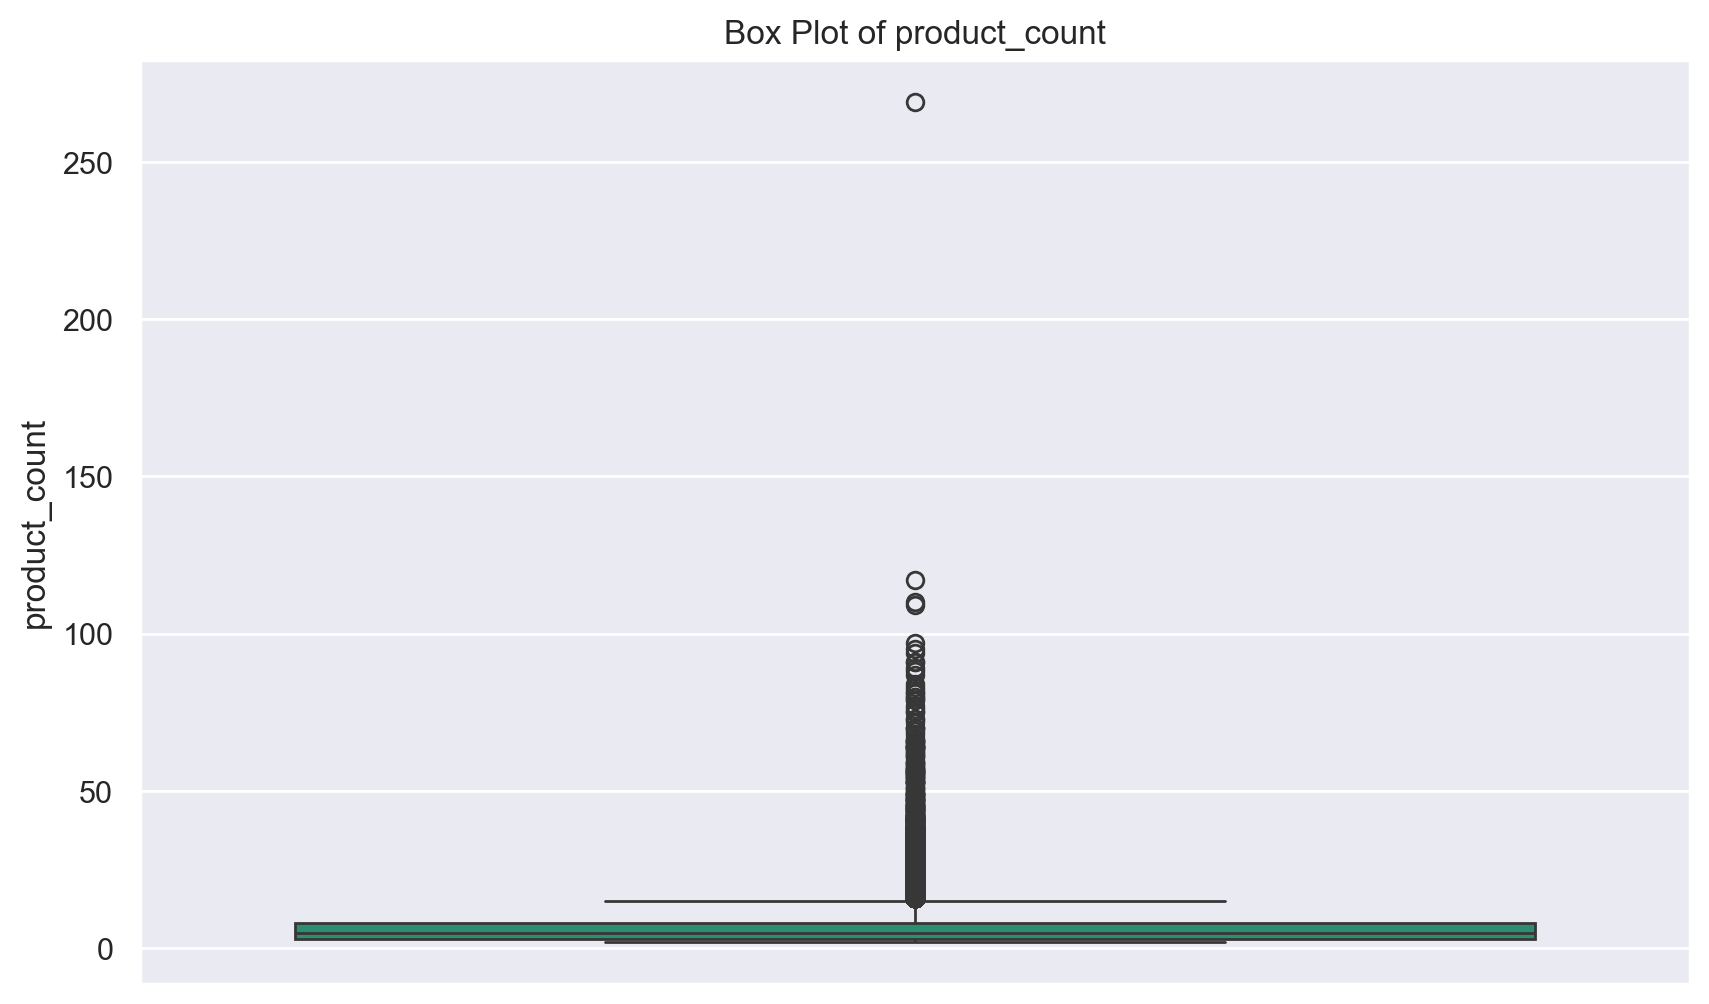

In [33]:
# plotting the graph with some of the outliers already removed for simplicity purposes
plt.figure(figsize=(10, 6))
sns.boxplot(data=food_df_out, y='product_count', palette='Dark2')
plt.title('Box Plot of product_count')
plt.ylabel('product_count')
plt.show()

In [34]:
extreme_lower_limit, extreme_upper_limit = boxplt_info_eo('product_count')
print(f" The lower limit is {extreme_lower_limit}, and the upper limit is {extreme_upper_limit}")

 The lower limit is -12.0, and the upper limit is 23


In [35]:
out_product_count = food_df[food_df['product_count'] > extreme_upper_limit] # saving outliers
out_product_count['product_count'].describe().round(2)

count    840.00
mean      35.42
std       15.76
min       24.00
25%       26.00
50%       31.00
75%       38.00
max      269.00
Name: product_count, dtype: float64

> - The were 840 extreme outliers identified.
> - The average value of the outliers identified is 35.42.
> - 50% of the outliers are below the value 31.
> - The lowest outlier has value 24 and the highest has value 269.

In [36]:
print(f"The dataset had {out_product_count.shape[0]} outliers.")
print(f"Considering previous iterations, there are only {food_df_out[food_df_out['product_count'] > extreme_upper_limit].shape[0]} outliers left.")

The dataset had 840 outliers.
Considering previous iterations, there are only 840 outliers left.


In [37]:
food_df_out = extreme_outliers_removal(food_df_out, 'product_count', extreme_lower_limit, extreme_upper_limit)
outliers_left(food_df_out, food_df)

 The percentage of data kept is: 93.46


__**Winsorization of values**__

In [38]:
lower_limit, upper_limit = boxplt_info('product_count')
print(f"There are still {food_df_out[food_df_out['product_count'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 984 outliers above the regular upper limit range.


> Setting the outliers still present to the value of the upper limit.

In [39]:
food_df_out['product_count'] = np.clip(food_df_out['product_count'], a_min=lower_limit, a_max=upper_limit) # Making sure the values of product count stay within the lower and upper bound range
print(f"There are still {food_df_out[food_df_out['product_count'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 0 outliers above the regular upper limit range.


    vendor_count

> From our EDA analysis, we see that both <code>product_count</code> and <code>vendor_count</code> are highly correlated, which indicates potential multicollinearity, so dropping one of them would help avoid redundancy. <br>
> At this point, we have decided not to treat this feature, as there is a very high chance it will be dropped. We believe informations about product patterns are more relevant for our analysis.

    total_orders

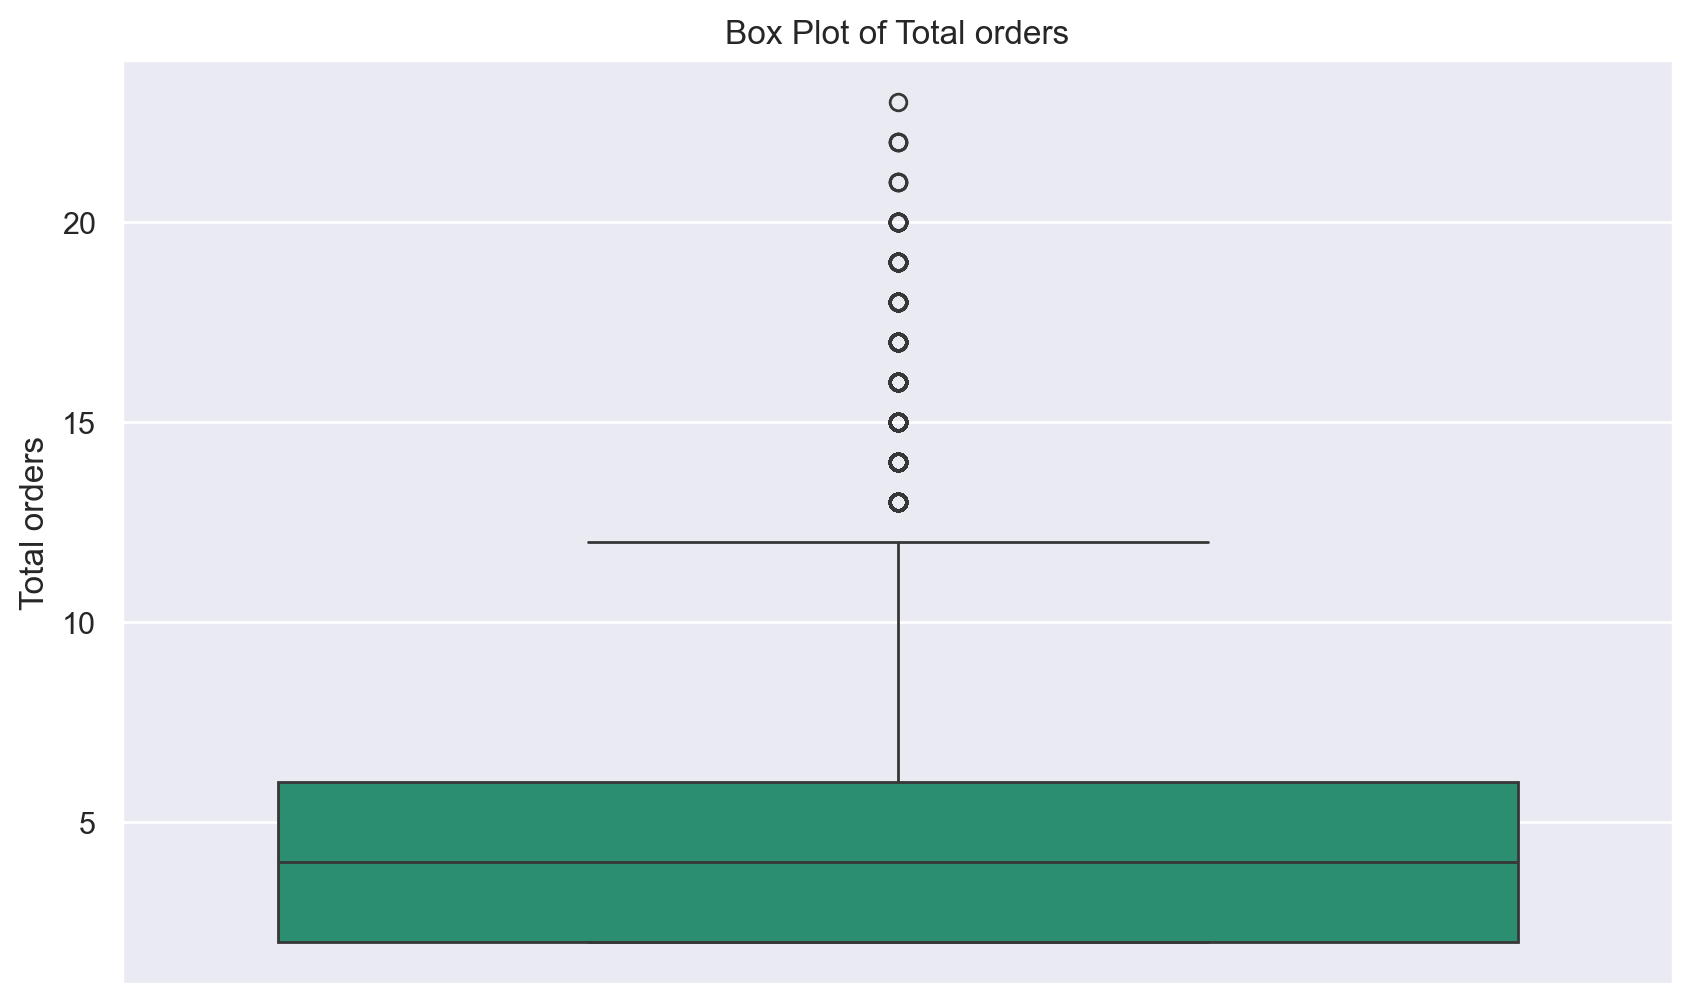

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=food_df_out, y='total_orders', palette='Dark2')
plt.title('Box Plot of Total orders')
plt.ylabel('Total orders')
plt.show()

In [41]:
extreme_lower_limit, extreme_upper_limit = boxplt_info_eo('total_orders')
print(f" The lower limit is {extreme_lower_limit}, and the upper limit is {extreme_upper_limit}")

 The lower limit is -10.0, and the upper limit is 18


In [42]:
out_total_orders = food_df[food_df['total_orders'] > ceil(extreme_upper_limit)] # saving outliers
out_total_orders ['total_orders'].describe().round(2)

count    746.00
mean      27.36
std       10.83
min       19.00
25%       21.00
50%       24.00
75%       30.00
max       94.00
Name: total_orders, dtype: float64

> - The were 746 extreme outliers identified.
> - The average value of the outliers identified is 27.36.
> - 50% of the outliers are below the value 24.
> - The lowest outlier has value 19 and the highest has value 94.

In [43]:
print(f"The dataset had {out_total_orders.shape[0]} outliers.")
print(f"Considering previous iterations, there are only {food_df_out[food_df_out['total_orders'] > extreme_upper_limit].shape[0]} outliers left.")

The dataset had 746 outliers.
Considering previous iterations, there are only 75 outliers left.


In [44]:
food_df_out = extreme_outliers_removal(food_df_out, 'total_orders', extreme_lower_limit, extreme_upper_limit) # removing them our auxiliary data set
outliers_left(food_df_out, food_df)

 The percentage of data kept is: 93.16


__**Winsorization of values**__

In [45]:
lower_limit, upper_limit = boxplt_info('total_orders')
print(f"There are still {food_df_out[food_df_out['total_orders'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 902 outliers above the regular upper limit range.


> Setting the outliers still present to the value of the upper limit.

In [46]:
food_df_out['total_orders'] = np.clip(food_df_out['total_orders'], a_min=lower_limit, a_max=upper_limit) # Making sure the values of product count stay within the lower and upper bound range
print(f"There are still {food_df_out[food_df_out['total_orders'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 0 outliers above the regular upper limit range.


    Weekday

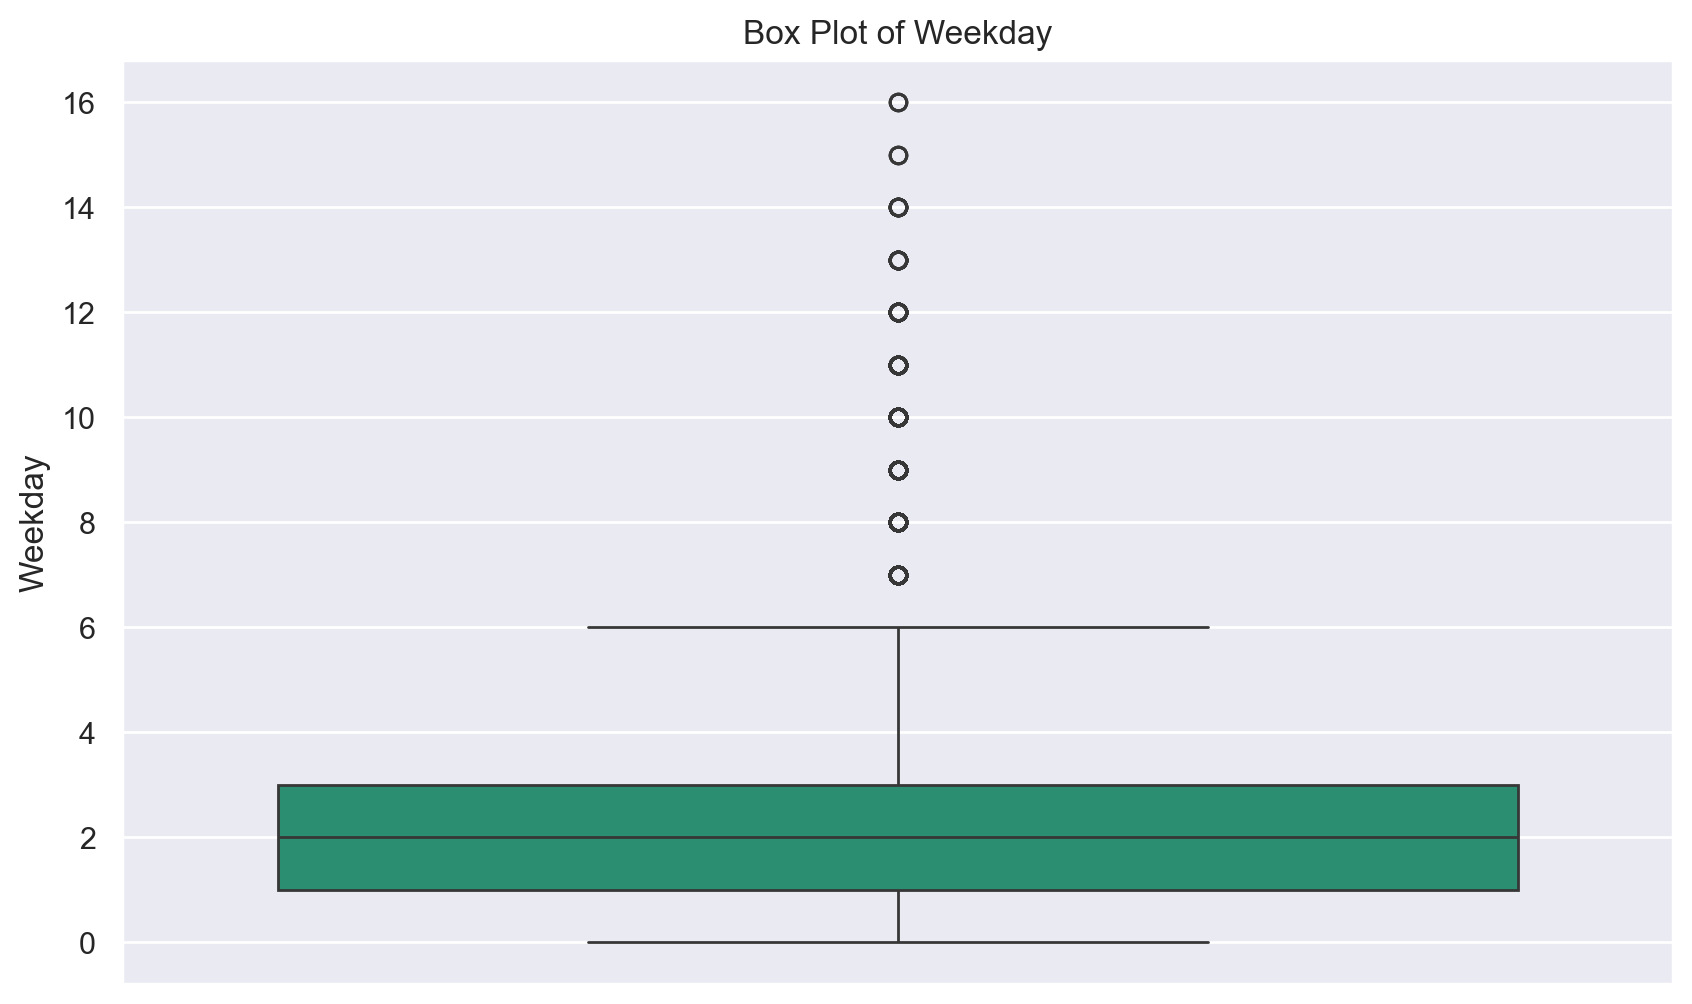

In [47]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=food_df_out, y='Weekday', palette='Dark2')
plt.title('Box Plot of Weekday')
plt.ylabel('Weekday')
plt.show()

In [48]:
extreme_lower_limit, extreme_upper_limit = boxplt_info_eo('Weekday')
print(f" The lower limit is {extreme_lower_limit}, and the upper limit is {extreme_upper_limit}")

 The lower limit is -5.0, and the upper limit is 9


In [49]:
out_weekday = food_df[food_df['Weekday'] > extreme_upper_limit] # saving outliers 
out_weekday['Weekday'].describe().round(2)

count    1092.00
mean       14.53
std         6.14
min        10.00
25%        11.00
50%        13.00
75%        16.00
max        60.00
Name: Weekday, dtype: float64

> - The were 1092 extreme outliers identified.
> - The average value of the outliers identified is 14.53.
> - 50% of the outliers are below the value 13.
> - The lowest outlier has value 10 and the highest has value 60.

In [50]:
print(f"The dataset had {out_weekday.shape[0]} outliers.")
print(f"Considering previous iterations, there are only {food_df_out[food_df_out['Weekday'] > extreme_upper_limit].shape[0]} outliers left.")

The dataset had 1092 outliers.
Considering previous iterations, there are only 360 outliers left.


In [51]:
food_df_out = extreme_outliers_removal(food_df_out, 'Weekday', extreme_lower_limit, extreme_upper_limit) # removing them our auxiliary data set
outliers_left(food_df_out, food_df)

 The percentage of data kept is: 91.71


__**Winsorization of values**__

In [52]:
lower_limit, upper_limit = boxplt_info('Weekday')
print(f"There are still {food_df_out[food_df_out['Weekday'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 1085 outliers above the regular upper limit range.


> Setting the outliers still present to the value of the upper limit.

In [53]:
food_df_out['Weekday'] = np.clip(food_df_out['Weekday'], a_min=lower_limit, a_max=upper_limit) # Making sure the values of product count stay within the lower and upper bound range
print(f"There are still {food_df_out[food_df_out['Weekday'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 0 outliers above the regular upper limit range.


    midday_orders

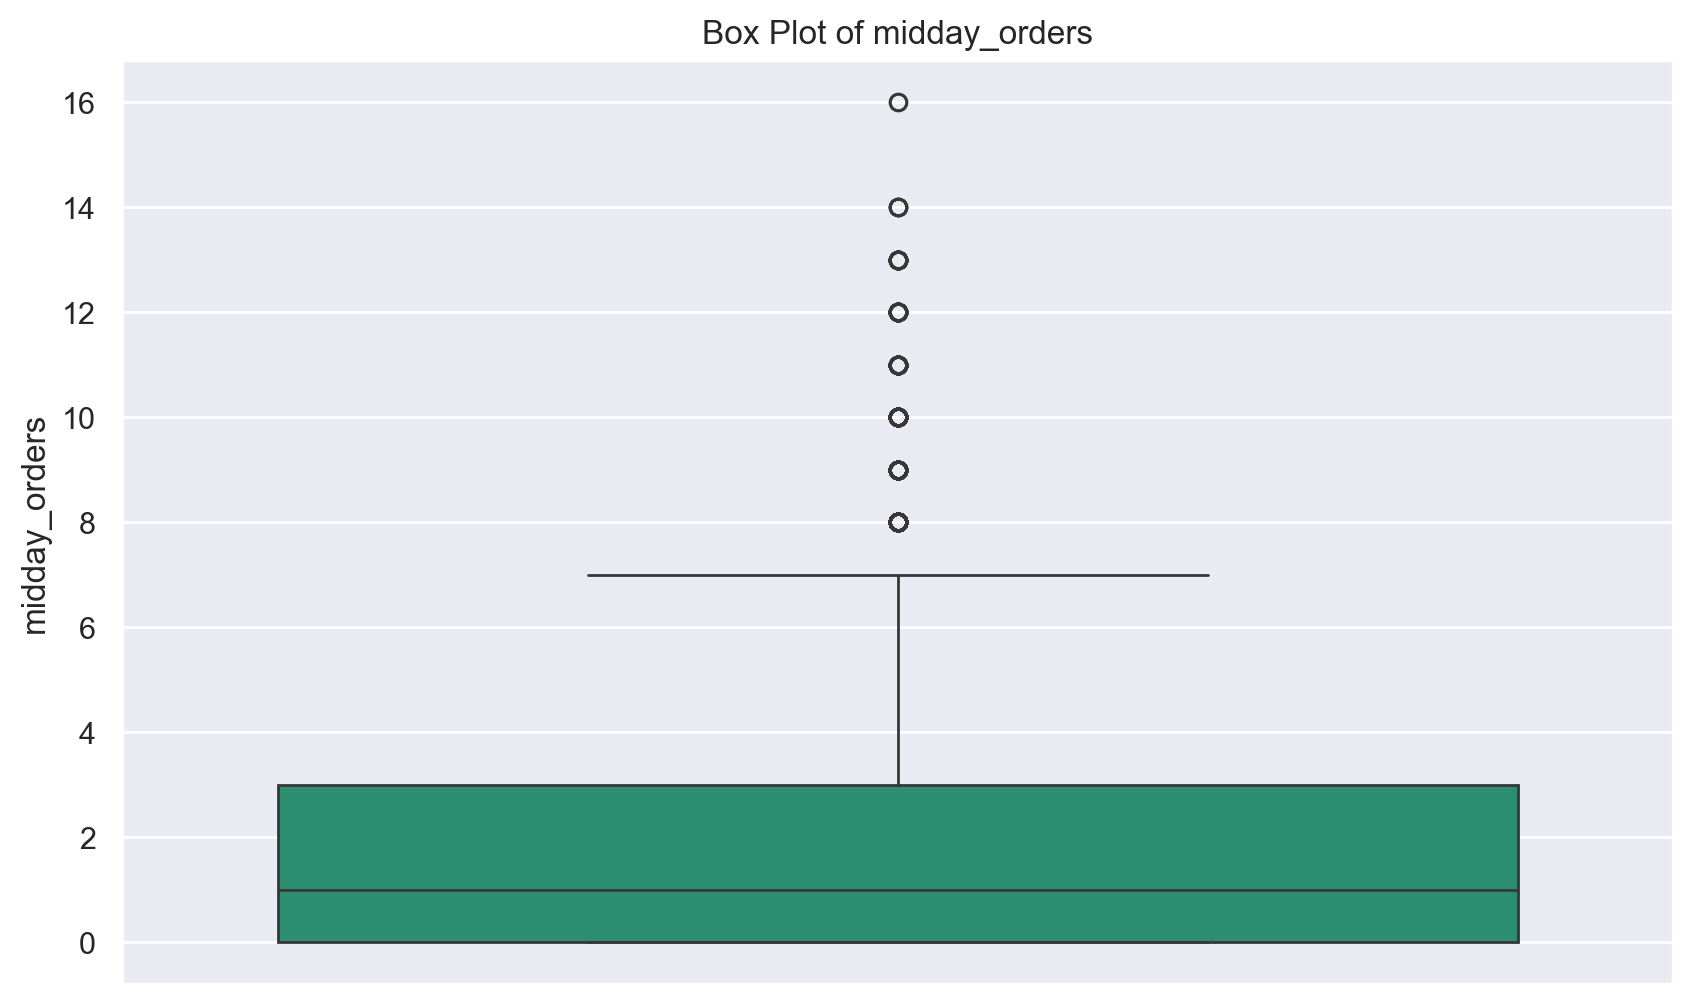

In [54]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=food_df_out, y='midday_orders', palette='Dark2')
plt.title('Box Plot of midday_orders')
plt.ylabel('midday_orders')
plt.show()

In [55]:
extreme_lower_limit, extreme_upper_limit = boxplt_info_eo('midday_orders')
print(f" The lower limit is {extreme_lower_limit}, and the upper limit is {extreme_upper_limit}")

 The lower limit is -5.0, and the upper limit is 9


In [56]:
out_midday_orders = food_df[food_df['midday_orders'] > extreme_upper_limit]
out_midday_orders['midday_orders'].describe().round(2)

count    823.00
mean      14.92
std        6.79
min       10.00
25%       11.00
50%       13.00
75%       16.00
max       71.00
Name: midday_orders, dtype: float64

> - The were 823 extreme outliers identified.
> - The average value of the outliers identified is 14.92.
> - 50% of the outliers are below the value 13.
> - The lowest outlier has value 10 and the highest has value 71.

In [57]:
print(f"The dataset had {out_midday_orders.shape[0]} outliers.")
print(f"Considering previous iterations, there are only {food_df_out[food_df_out['midday_orders'] > extreme_upper_limit].shape[0]} outliers left.")

The dataset had 823 outliers.
Considering previous iterations, there are only 180 outliers left.


In [58]:
food_df_out = extreme_outliers_removal(food_df_out, 'midday_orders', extreme_lower_limit, extreme_upper_limit)
outliers_left(food_df_out, food_df)

 The percentage of data kept is: 90.99


__**Winsorization of values**__

In [59]:
lower_limit, upper_limit = boxplt_info('midday_orders')
print(f"There are still {food_df_out[food_df_out['midday_orders'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 698 outliers above the regular upper limit range.


> Setting the outliers still present to the value of the upper limit.

In [60]:
food_df_out['midday_orders'] = np.clip(food_df_out['midday_orders'], a_min=lower_limit, a_max=upper_limit) # Making sure the values of product count stay within the lower and upper bound range
print(f"There are still {food_df_out[food_df_out['midday_orders'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 0 outliers above the regular upper limit range.


    evening_orders

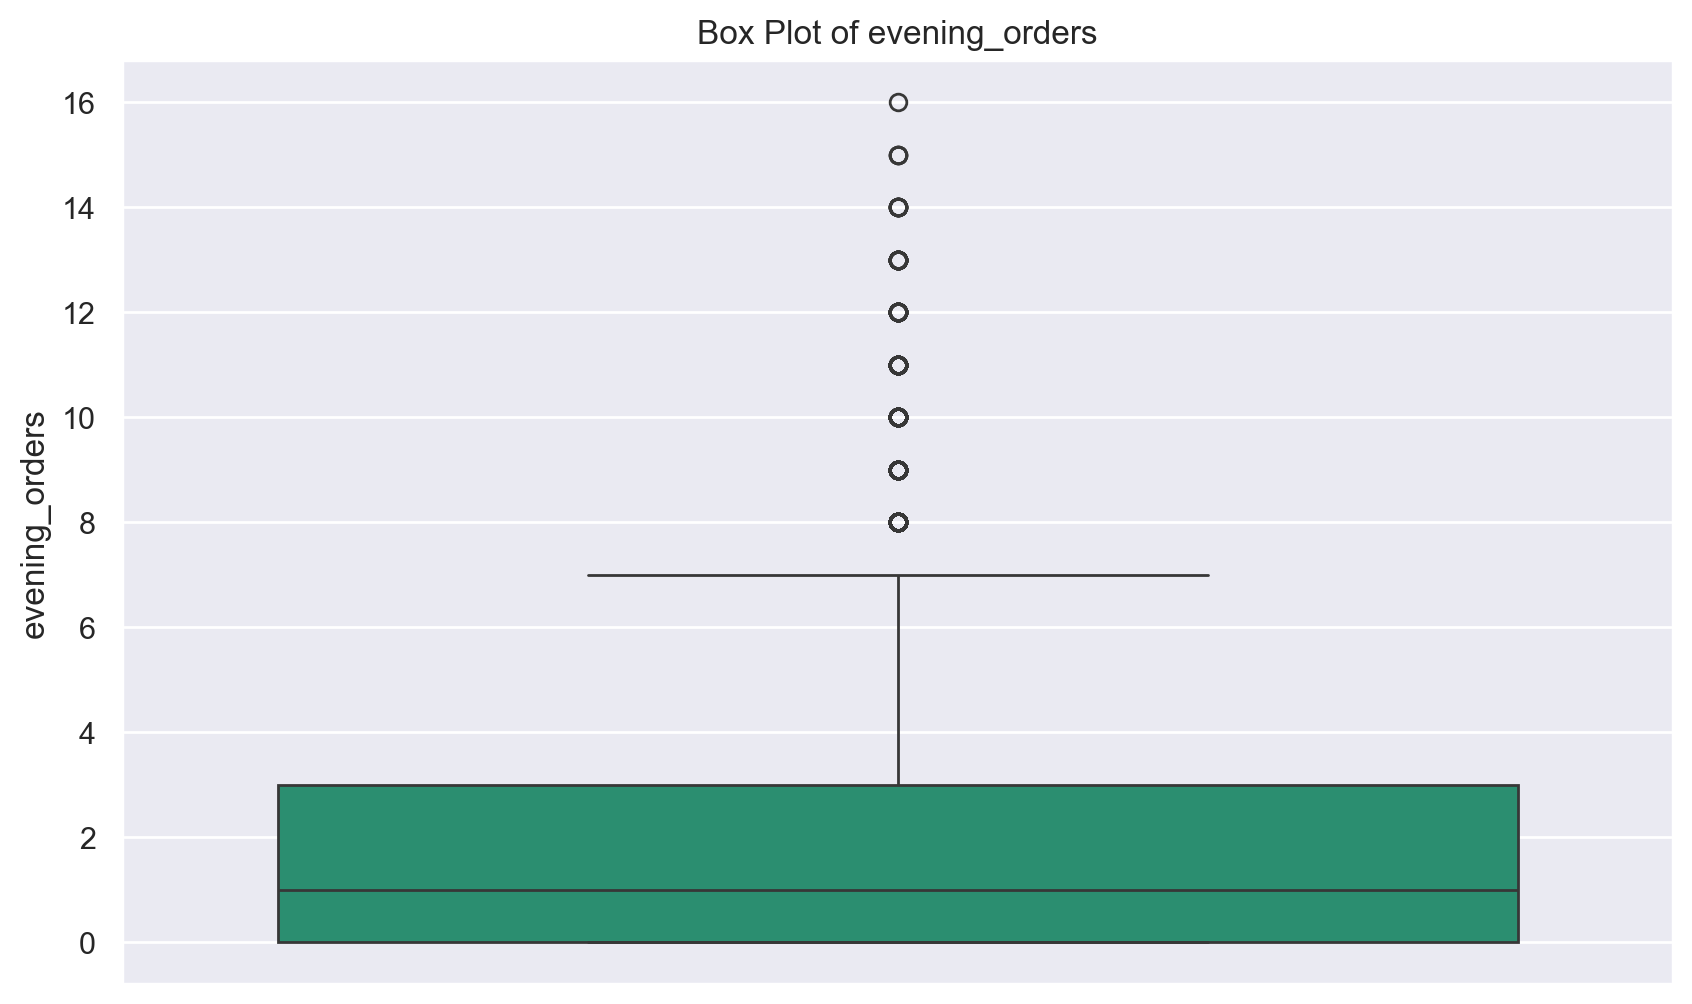

In [61]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=food_df_out, y='evening_orders', palette='Dark2')
plt.title('Box Plot of evening_orders')
plt.ylabel('evening_orders')
plt.show()

In [62]:
extreme_lower_limit, extreme_upper_limit = boxplt_info_eo('evening_orders')
print(f" The lower limit is {extreme_lower_limit}, and the upper limit is {extreme_upper_limit}")

 The lower limit is -9.0, and the upper limit is 12


In [63]:
out_evening_orders = food_df[food_df['evening_orders'] > extreme_upper_limit] 
out_evening_orders['evening_orders'].describe().round(2)

count    409.00
mean      17.96
std        6.66
min       13.00
25%       14.00
50%       16.00
75%       20.00
max       61.00
Name: evening_orders, dtype: float64

> - The were 409 extreme outliers identified.
> - The average value of the outliers identified is 17.96.
> - 50% of the outliers are below the value 16.
> - The lowest outlier has value 13 and the highest has value 61.

In [64]:
print(f"The dataset had {out_evening_orders.shape[0]} outliers.")
print(f"Considering previous iterations, there are only {food_df_out[food_df_out['evening_orders'] > extreme_upper_limit].shape[0]} outliers left.")

The dataset had 409 outliers.
Considering previous iterations, there are only 44 outliers left.


In [65]:
food_df_out = extreme_outliers_removal(food_df_out, 'evening_orders', extreme_lower_limit, extreme_upper_limit)
outliers_left(food_df_out, food_df)

 The percentage of data kept is: 90.81


__**Winsorization of values**__

In [66]:
lower_limit, upper_limit = boxplt_info('evening_orders')
print(f"There are still {food_df_out[food_df_out['evening_orders'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 367 outliers above the regular upper limit range.


> Setting the outliers still present to the value of the upper limit.

In [67]:
food_df_out['evening_orders'] = np.clip(food_df_out['evening_orders'], a_min=lower_limit, a_max=upper_limit) # Making sure the values of product count stay within the lower and upper bound range
print(f"There are still {food_df_out[food_df_out['evening_orders'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 0 outliers above the regular upper limit range.


    total_spent

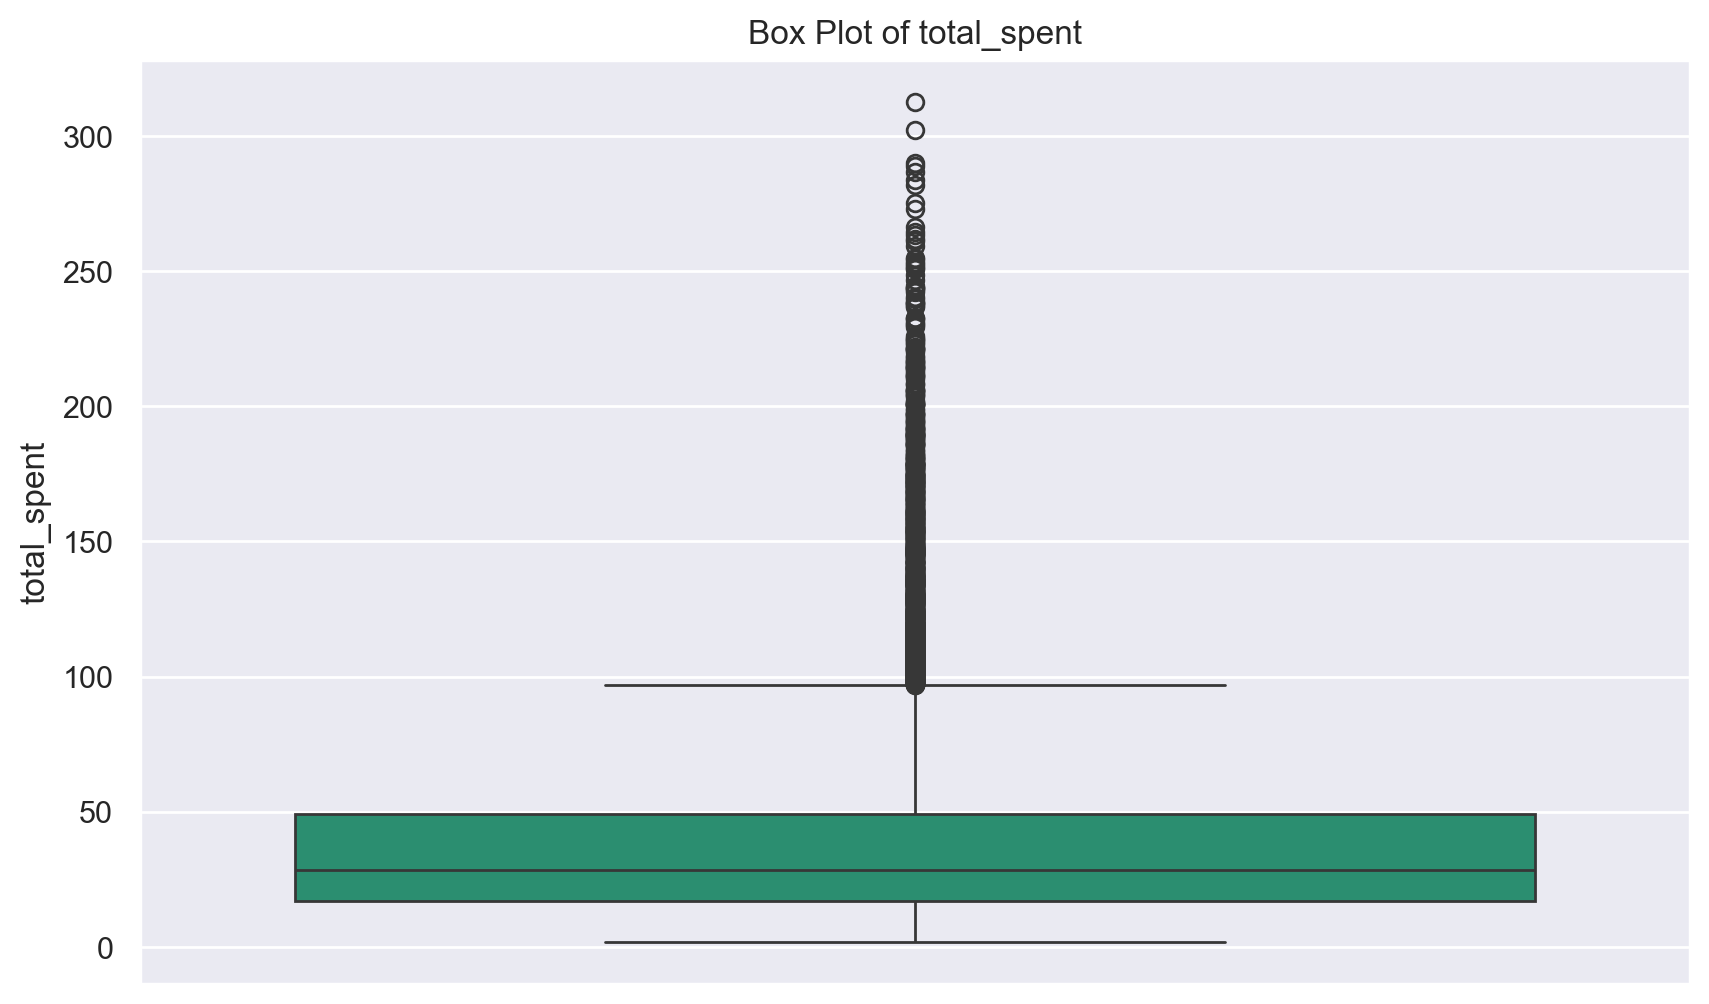

In [68]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=food_df_out, y='total_spent', palette='Dark2')
plt.title('Box Plot of total_spent')
plt.ylabel('total_spent')
plt.show()

In [69]:
extreme_lower_limit, extreme_upper_limit = boxplt_info_eo('total_spent')
print(f" The lower limit is {extreme_lower_limit}, and the upper limit is {extreme_upper_limit}")

 The lower limit is -94.15, and the upper limit is 167


In [70]:
out_total_spent = food_df[food_df['total_spent'] > extreme_upper_limit]
out_total_spent['total_spent'].describe().round(2)

count     750.00
mean      244.76
std        99.64
min       167.10
25%       185.51
50%       213.96
75%       268.87
max      1418.33
Name: total_spent, dtype: float64

> - The were 750 extreme outliers identified.
> - The average value of the outliers identified is 244.76.
> - 50% of the outliers are below the value 213.96.
> - The lowest outlier has value 167 and the highest has value 1418.

In [71]:
print(f"The dataset had {out_total_spent.shape[0]} outliers.")
print(f"Considering previous iterations, there are only {food_df_out[food_df_out['total_spent'] > extreme_upper_limit].shape[0]} outliers left.")

The dataset had 750 outliers.
Considering previous iterations, there are only 255 outliers left.


In [72]:
food_df_out = extreme_outliers_removal(food_df_out, 'total_spent', extreme_lower_limit, extreme_upper_limit)
outliers_left(food_df_out, food_df)

 The percentage of data kept is: 89.78


__**Winsorization of values**__

In [73]:
lower_limit, upper_limit = boxplt_info('total_spent')
print(f"There are still {food_df_out[food_df_out['total_spent'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 722 outliers above the regular upper limit range.


> Setting the outliers still present to the value of the upper limit.

In [74]:
food_df_out['total_spent'] = np.clip(food_df_out['total_spent'], a_min=lower_limit, a_max=upper_limit) # Making sure the values of product count stay within the lower and upper bound range
print(f"There are still {food_df_out[food_df_out['total_spent'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 0 outliers above the regular upper limit range.


    Weekend

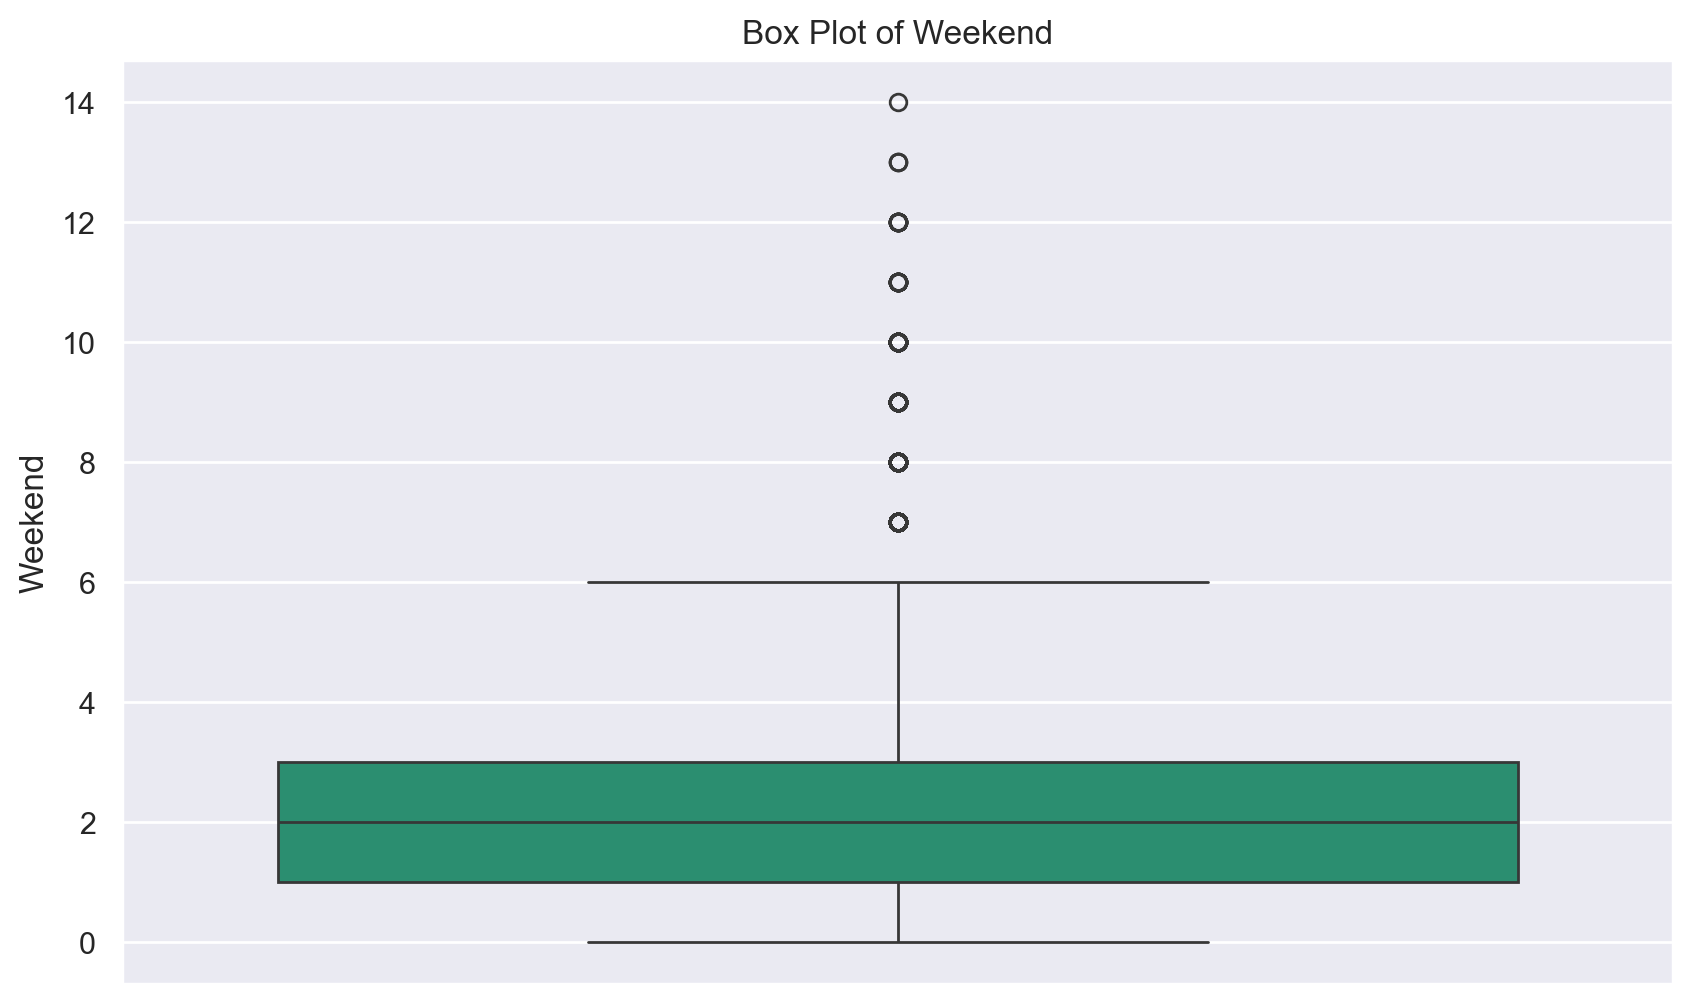

In [75]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=food_df_out, y='Weekend', palette='Dark2')
plt.title('Box Plot of Weekend')
plt.ylabel('Weekend')
plt.show()

In [76]:
extreme_lower_limit, extreme_upper_limit = boxplt_info_eo('Weekend')
print(f" The lower limit is {extreme_lower_limit}, and the upper limit is {extreme_upper_limit}")

 The lower limit is -5.0, and the upper limit is 9


In [77]:
out_Weekend = food_df[food_df['Weekend'] > extreme_upper_limit] # saving outliers
out_Weekend['Weekend'].describe().round(2)

count    595.00
mean      13.96
std        5.13
min       10.00
25%       10.50
50%       12.00
75%       15.50
max       45.00
Name: Weekend, dtype: float64

> - The were 595 extreme outliers identified.
> - The average value of the outliers identified is 13.96.
> - 50% of the outliers are below the value 12.
> - The lowest outlier has value 10 and the highest has value 45.

In [78]:
print(f"The dataset had {out_Weekend.shape[0]} outliers.")
print(f"Considering previous iterations, there are only {food_df_out[food_df_out['Weekend'] > extreme_upper_limit].shape[0]} outliers left.")

The dataset had 595 outliers.
Considering previous iterations, there are only 89 outliers left.


In [79]:
food_df_out = extreme_outliers_removal(food_df_out, 'Weekend', extreme_lower_limit, extreme_upper_limit)
outliers_left(food_df_out, food_df)

 The percentage of data kept is: 89.42


__**Winsorization of values**__

In [80]:
lower_limit, upper_limit = boxplt_info('Weekend')
print(f"There are still {food_df_out[food_df_out['Weekend'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 513 outliers above the regular upper limit range.


> Setting the outliers still present to the value of the upper limit.

In [81]:
food_df_out['Weekend'] = np.clip(food_df_out['Weekend'], a_min=lower_limit, a_max=upper_limit) # Making sure the values of product count stay within the lower and upper bound range
print(f"There are still {food_df_out[food_df_out['Weekend'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 0 outliers above the regular upper limit range.


### DECIDE WHAT TO DO WITH LATE NIGHT ORDERS CUZ OUTLIER IS >11%

    late_night_orders

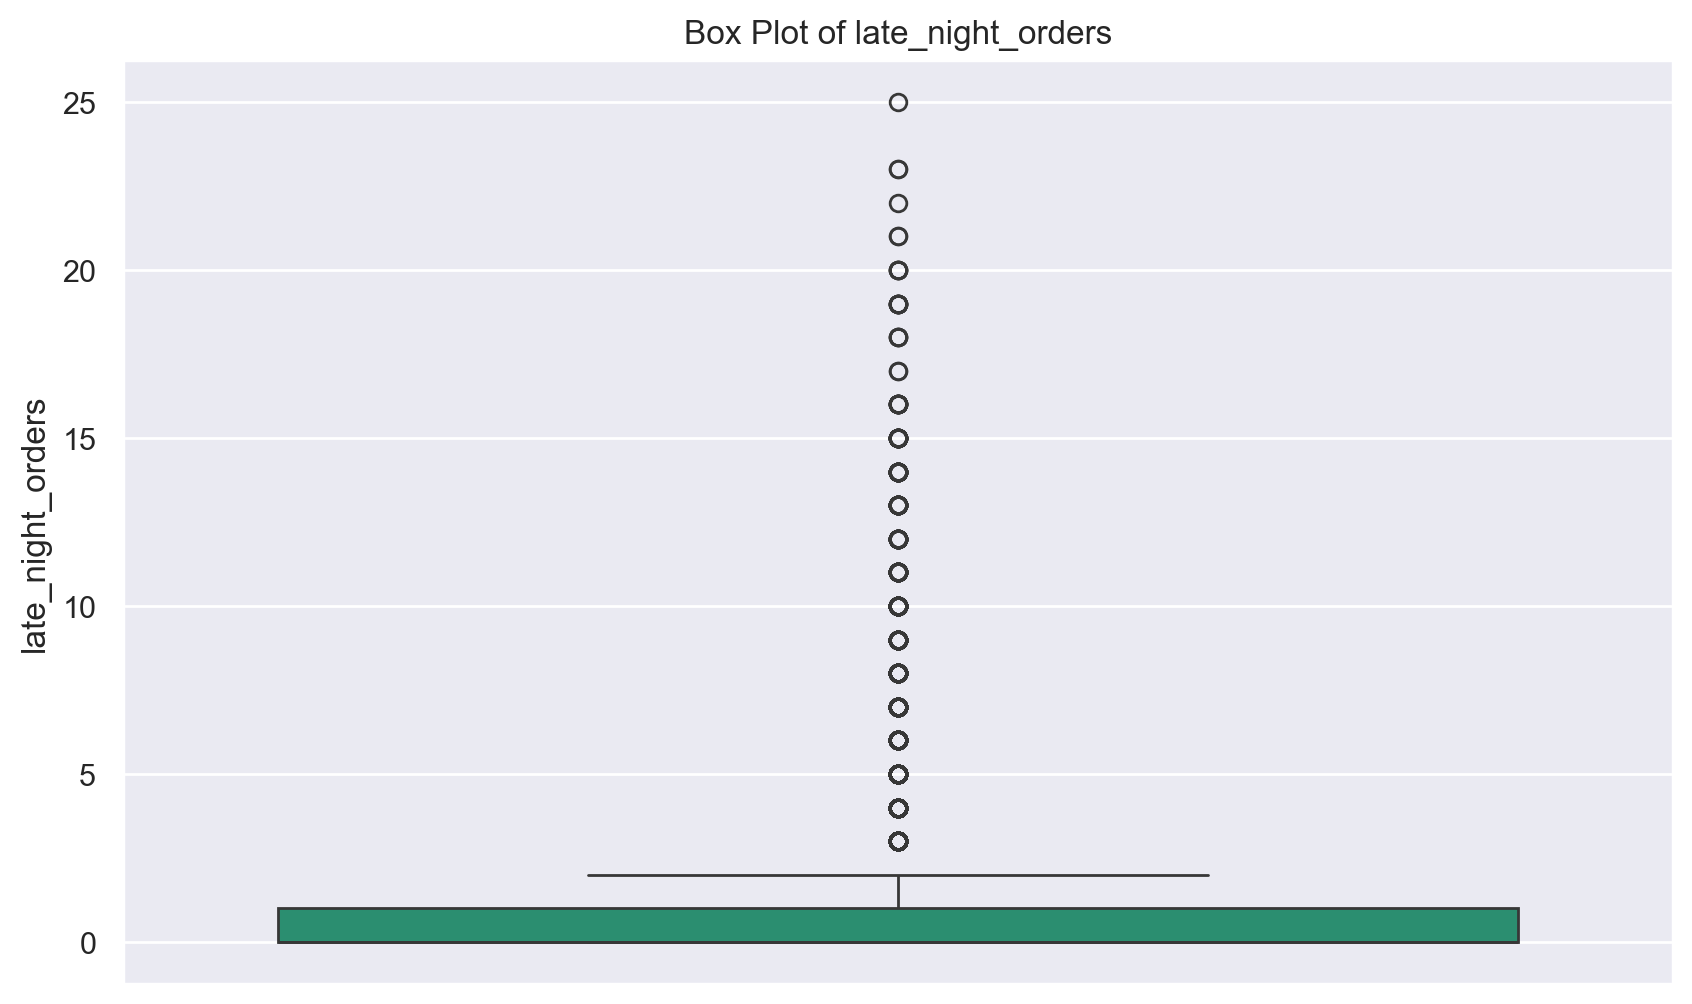

In [82]:
# plotting the graph with some of the outliers already removed for simplicity purposes
plt.figure(figsize=(10, 6))
sns.boxplot(data=food_df_out, y='late_night_orders', palette='Dark2')
plt.title('Box Plot of late_night_orders')
plt.ylabel('late_night_orders')
plt.show()

In [83]:
extreme_lower_limit, extreme_upper_limit = boxplt_info_eo('late_night_orders')
print(f" The lower limit is {extreme_lower_limit}, and the upper limit is {extreme_upper_limit}")

 The lower limit is -3.0, and the upper limit is 4


In [84]:
out_late_night_orders = food_df[food_df['late_night_orders'] > extreme_upper_limit] # saving outliers
out_late_night_orders['late_night_orders'].describe().round(2)

count    1325.00
mean       10.37
std         8.17
min         5.00
25%         6.00
50%         8.00
75%        12.00
max        81.00
Name: late_night_orders, dtype: float64

> - The were 1325 extreme outliers identified.
> - The average value of the outliers identified is 10.37.
> - 50% of the outliers are below the value 8.
> - The lowest outlier has value 5 and the highest has value 81.

In [85]:
print(f"The dataset had {out_late_night_orders.shape[0]} outliers.")
print(f"Considering previous iterations, there are only {food_df_out[food_df_out['late_night_orders'] > extreme_upper_limit].shape[0]} outliers left.")

The dataset had 1325 outliers.
Considering previous iterations, there are only 926 outliers left.


In [86]:
food_df_out = extreme_outliers_removal(food_df_out, 'late_night_orders', extreme_lower_limit, extreme_upper_limit)
outliers_left(food_df_out, food_df)

 The percentage of data kept is: 85.69


__**Winsorization of values**__

In [87]:
lower_limit, upper_limit = boxplt_info('late_night_orders')
print(f"There are still {food_df_out[food_df_out['late_night_orders'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 464 outliers above the regular upper limit range.


> Setting the outliers still present to the value of the upper limit.

In [88]:
food_df_out['late_night_orders'] = np.clip(food_df_out['late_night_orders'], a_min=lower_limit, a_max=upper_limit) # Making sure the values of product count stay within the lower and upper bound range
print(f"There are still {food_df_out[food_df_out['late_night_orders'] > upper_limit].shape[0]} outliers above the regular upper limit range.")

There are still 0 outliers above the regular upper limit range.


__**Plotting Box Plots**__

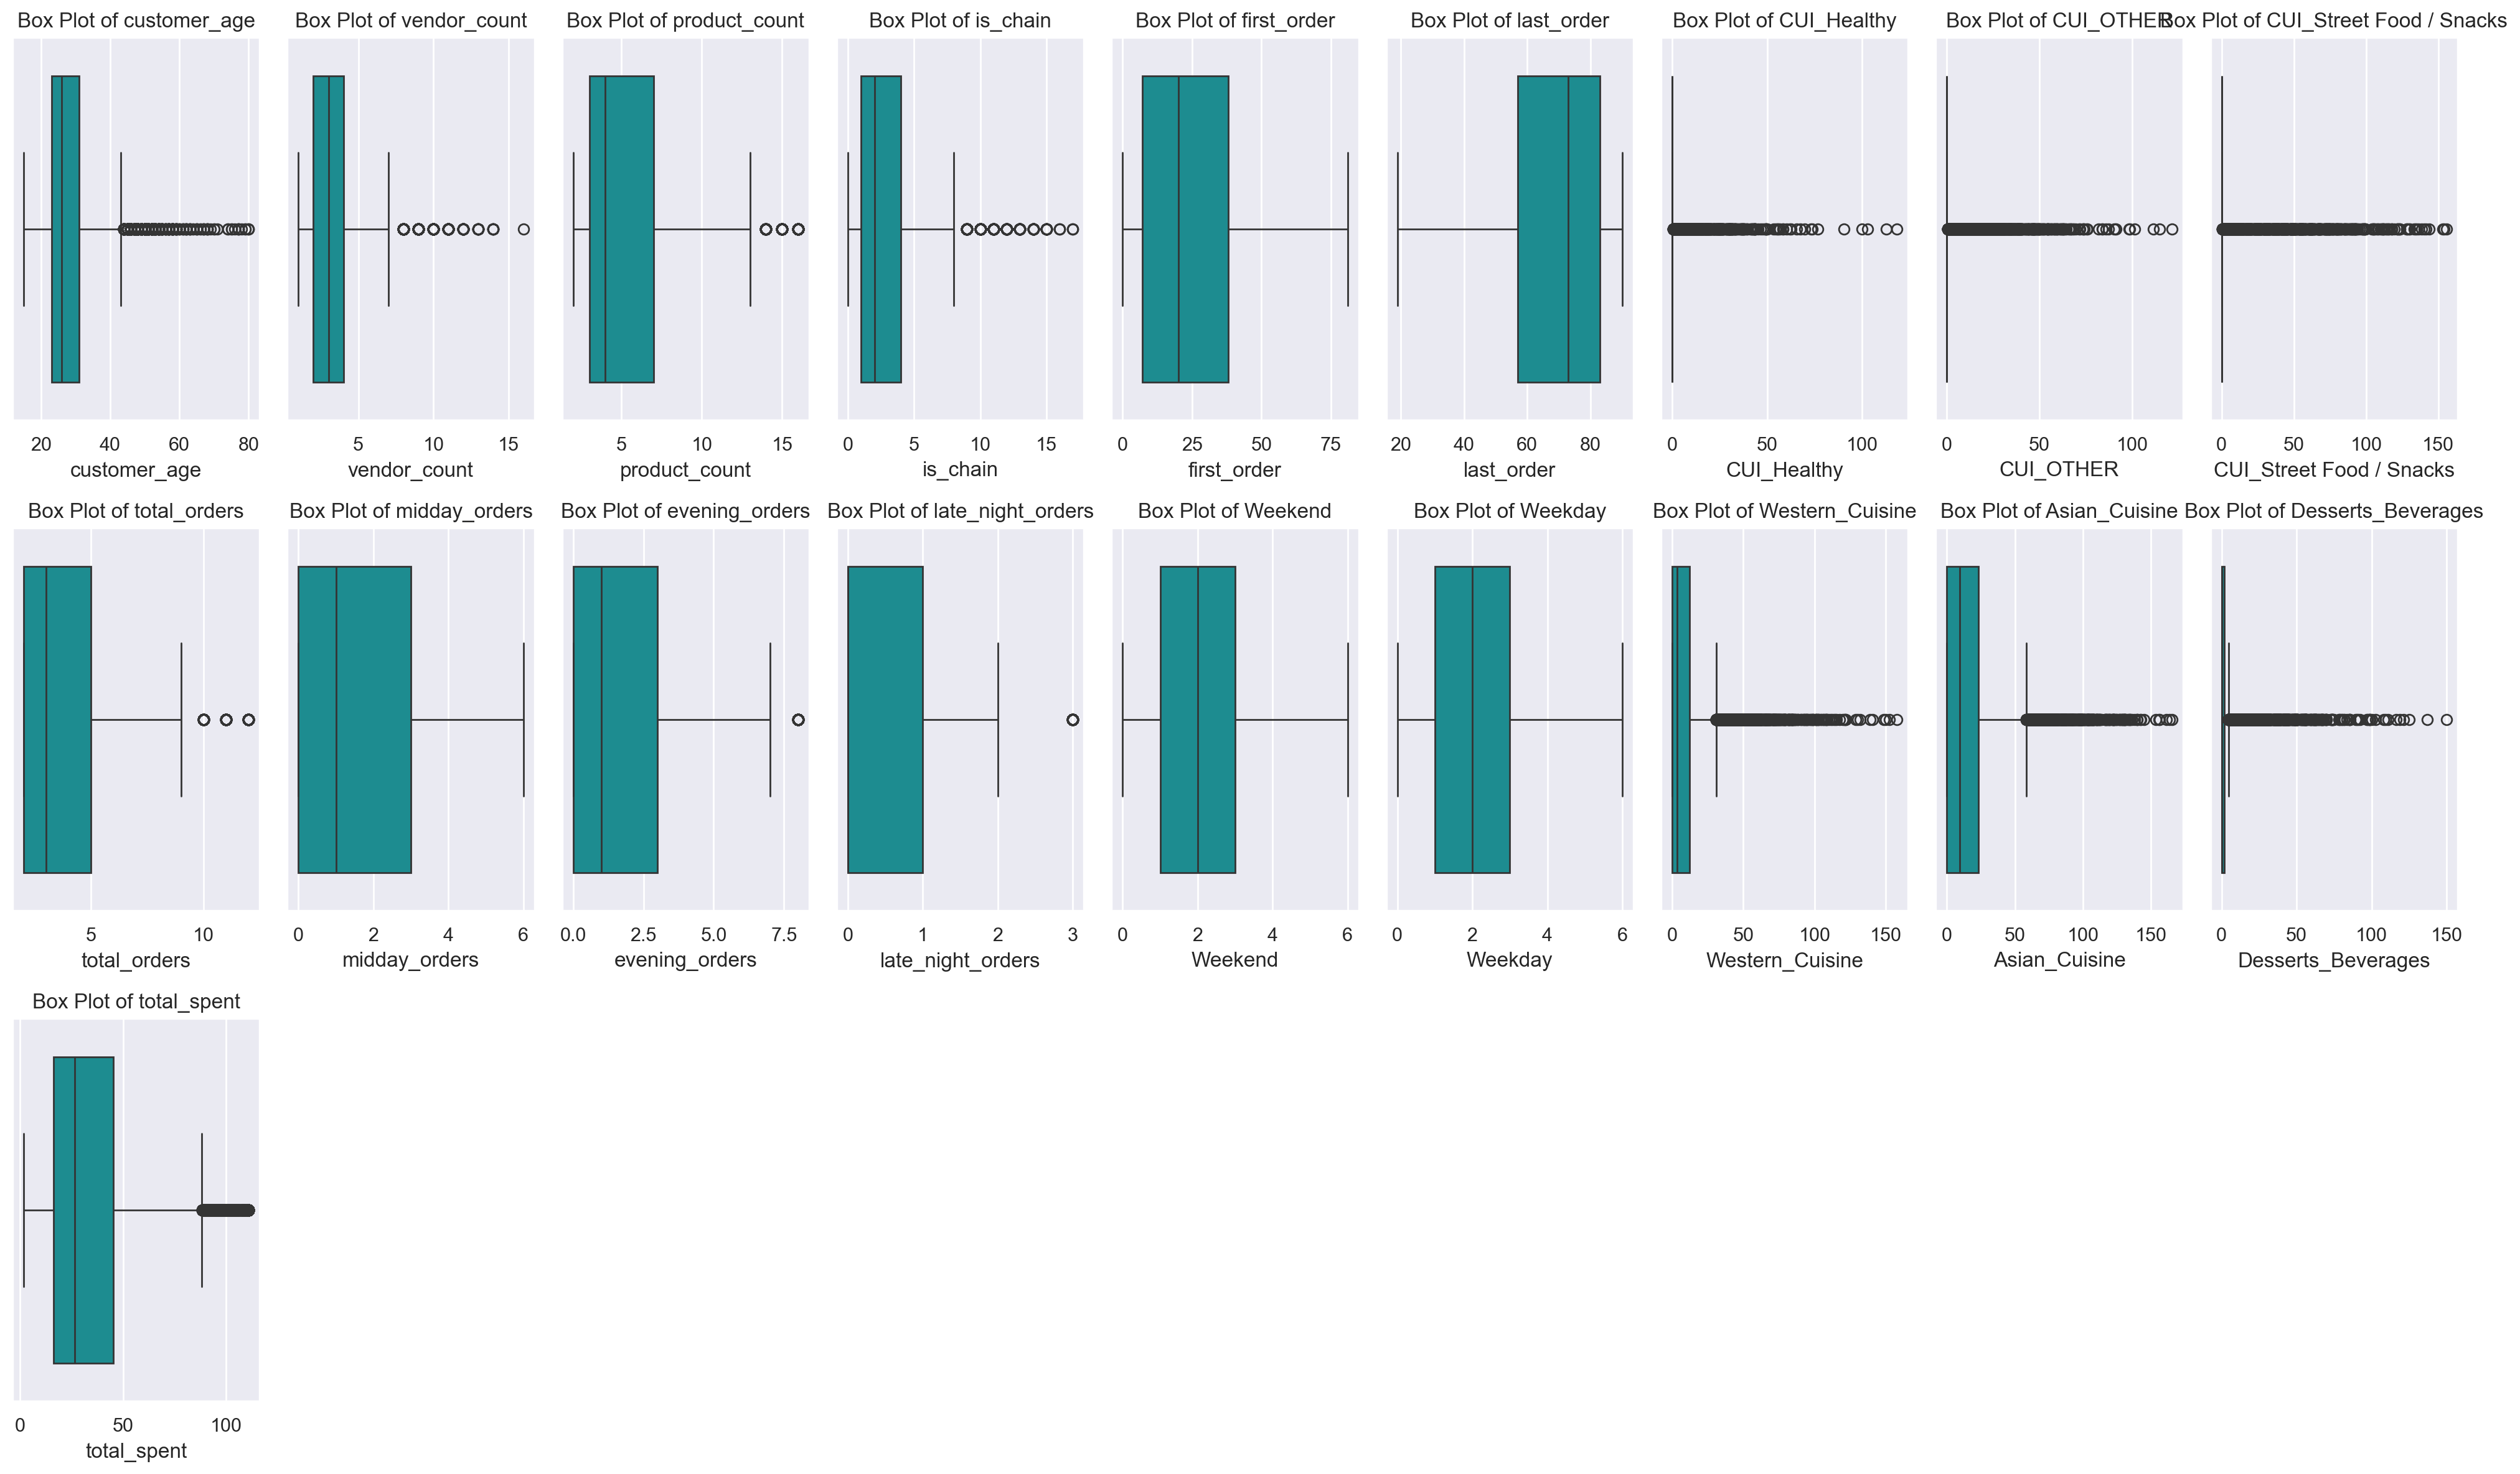

In [89]:
# Final boxplots of all numerical variables
n_cols = 9
n_rows = -(-len(num_columns) // n_cols)  # Calculate rows needed

# Set the figure size for readability
plt.figure(figsize=(20, 4 * n_rows))

# Plot each numerical column in a separate horizontal box plot
for i, column in enumerate(num_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=food_df_out, x=column, color = colors['BL'])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()

In [90]:
food_df = food_df_out #updating our current dataset

## 5. Feature Engineering

In this section, we will  create and explore new features that may be relevant for our segmentation. We are creating features from variables where outliers were already treated so we believe our data is robust.

    average_spent_per_order

> We wanted to see the average amount of money spent per customer on one order. <br>
> This feature can help us identify trends with customer's spending habits.

In [91]:
food_df['average_spent_per_order'] = (food_df['total_spent'] / food_df['total_orders']).round(2)

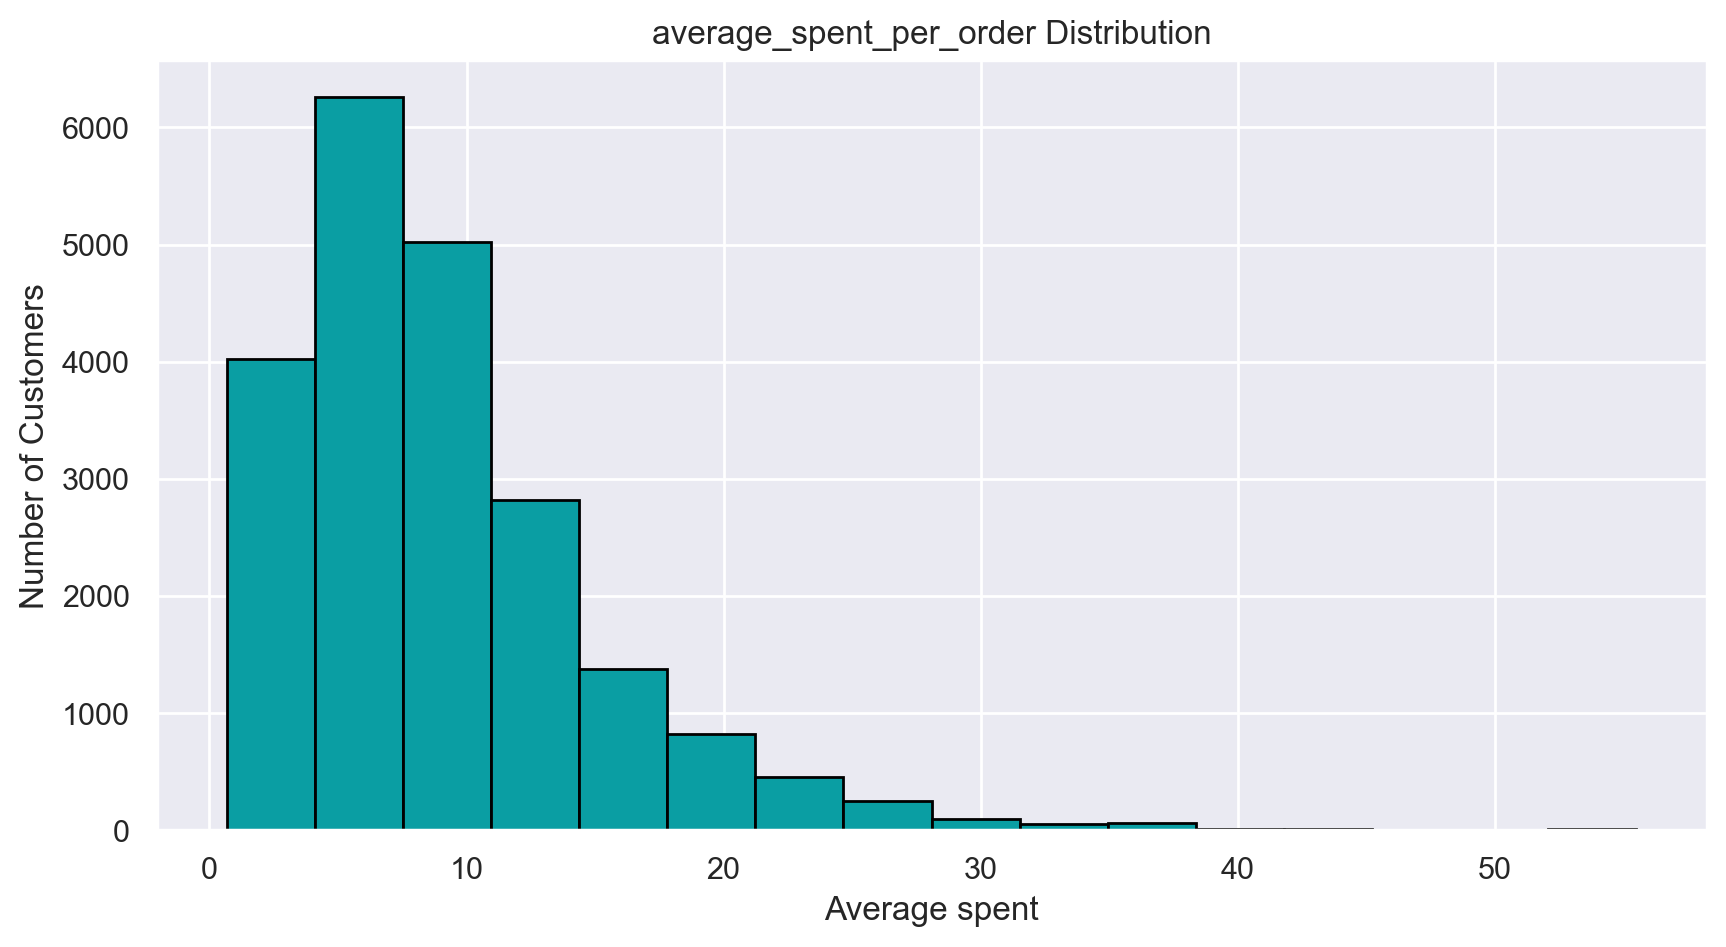

In [92]:
plt.figure(figsize=(10, 5))
plt.hist(food_df['average_spent_per_order'], bins=number_bins_sturges(food_df['average_spent_per_order']), color=colors["BL"], edgecolor='black')
plt.title('average_spent_per_order Distribution')
plt.xlabel('Average spent')
plt.ylabel('Number of Customers')
plt.show()

> - Right Skewed Distribution with values from 0.68 to 55.5.
> - We can see the presence of some cases where more money was spent per order.

    customer_lifetime

In [93]:
food_df['customer_lifetime'] = (food_df['last_order'] - food_df['first_order']) + 1

In [95]:
food_df['customer_lifetime'].describe().round(2)

count    21277.00
mean        44.46
std         24.16
min          1.00
25%         24.00
50%         45.00
75%         65.00
max         91.00
Name: customer_lifetime, dtype: float64

> - Our customers have a lifetime, on average, of 45 days.
> - This is without considering the one-time customers.

# PAREI AQUI, MAS ISTO TEM DE SER MUITO BEM PENSADO

    percent_chain_orders

In [150]:
food_df['percent_chain_orders'] = (food_df['is_chain'] / food_df['total_orders'].replace(0, np.nan)).round(3) #Getting the percentage chain orders

KeyError: 'is_chain'

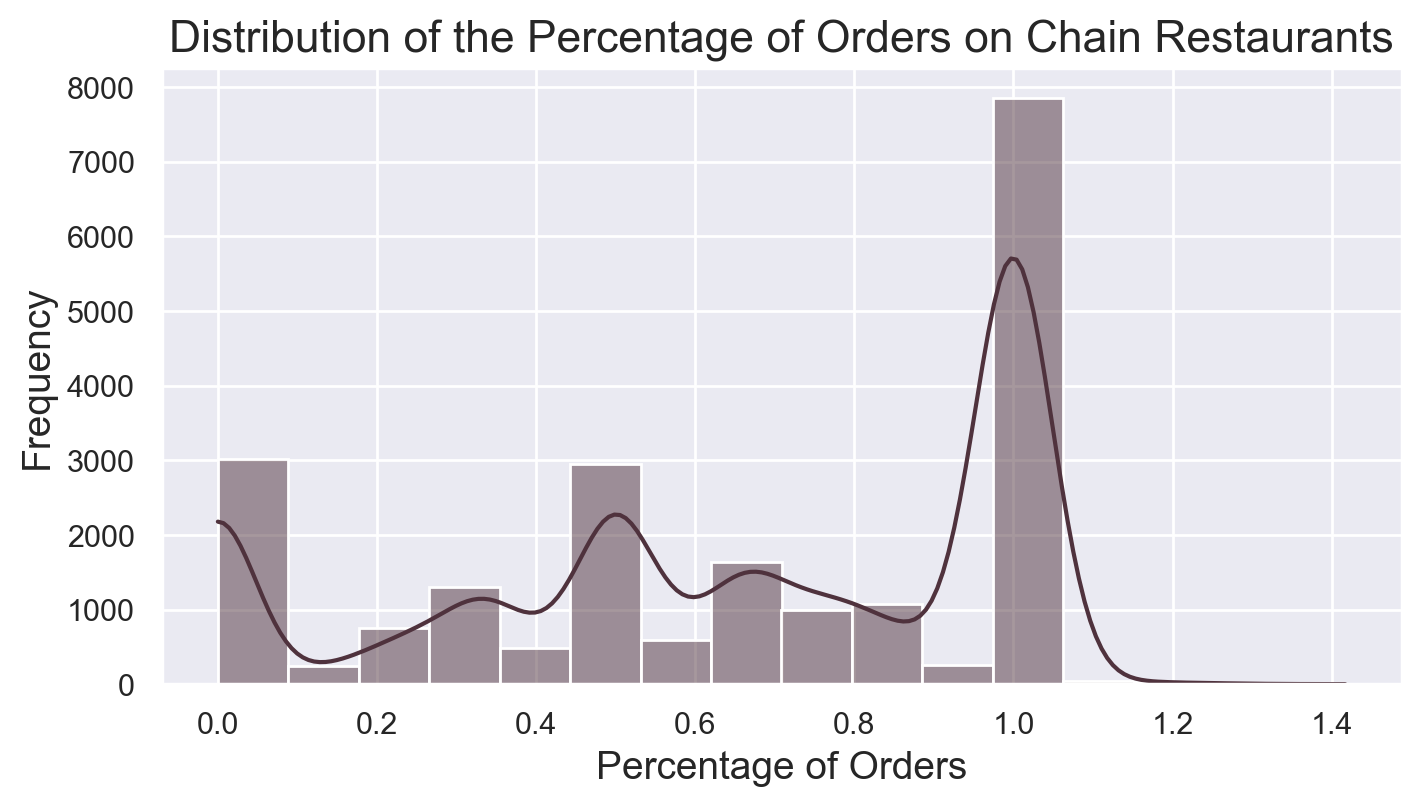

In [117]:
plt.figure(figsize=(8, 4))
sns.histplot(food_df['percent_chain_orders'].dropna(), bins=number_bins_sturges(food_df['percent_chain_orders']), kde=True, color=colors["BR"])
plt.title('Distribution of the Percentage of Orders on Chain Restaurants', fontsize=16)
plt.xlabel('Percentage of Orders', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()


We can observe that most of the people that buy from chain restaurants, only buy from chain restaurants.

In [118]:
#Create categorical feature for is chain
# Define bins and labels for the feature
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
# Create a new categorical column
food_df['chain_category'] = pd.cut(food_df['percent_chain_orders'], bins=bins, labels=labels, include_lowest=True)
# Check the distribution
print(food_df['chain_category'].value_counts())

Very High    8733
Moderate     3684
Very Low     3472
High         3090
Low          2198
Name: chain_category, dtype: int64


In [119]:
food_df['chain_category'] = food_df['chain_category'].astype('object')

In [120]:
food_df = food_df.drop(columns=['percent_chain_orders', 'is_chain'])

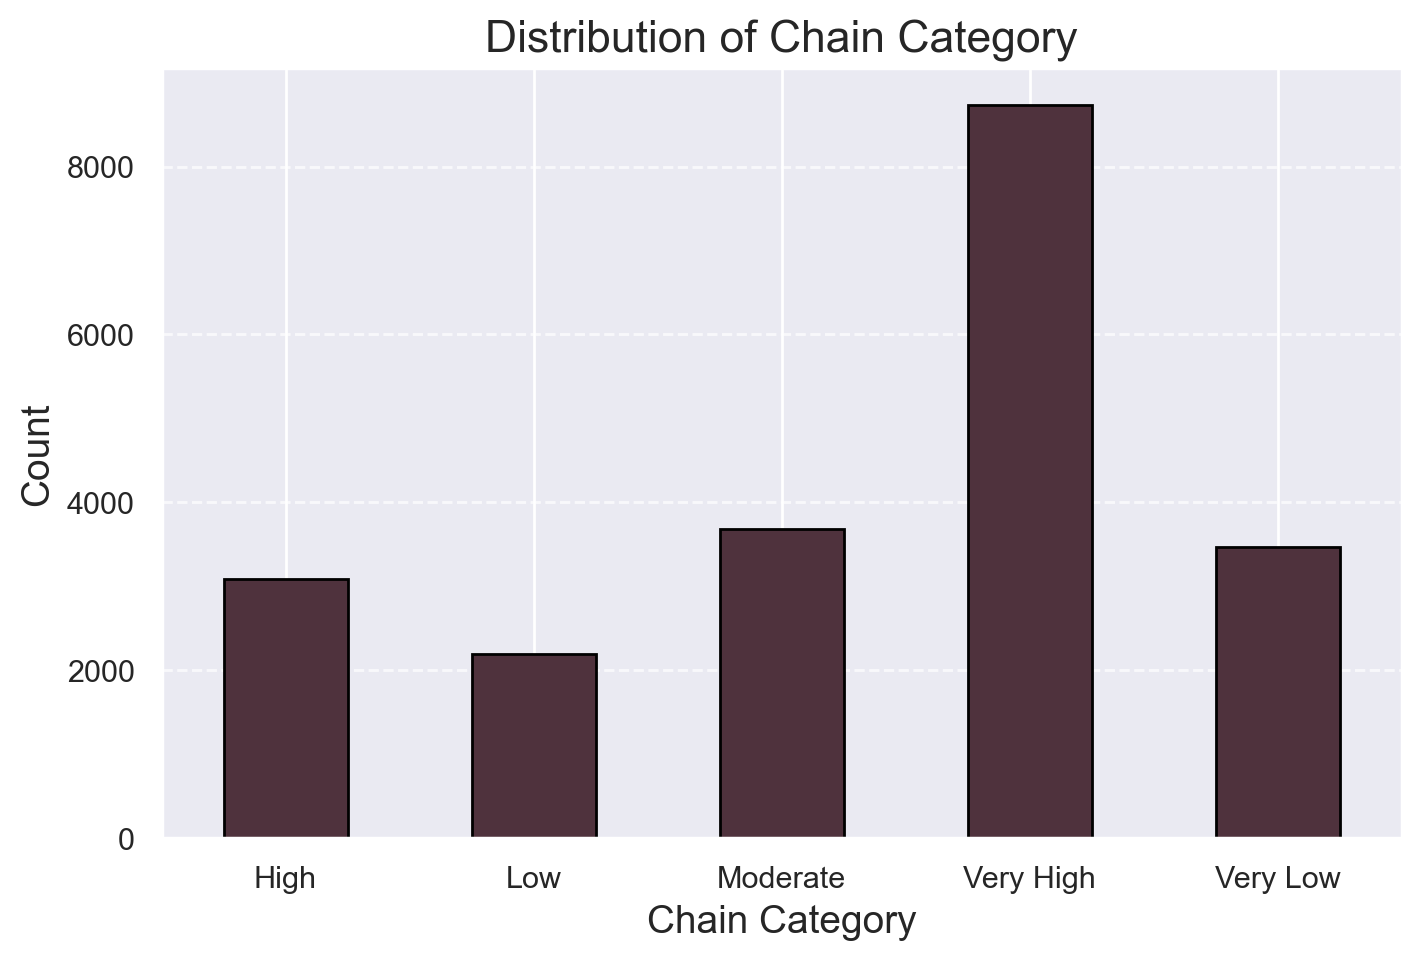

In [121]:
# Count the occurrences of each category
category_counts = food_df['chain_category'].value_counts()

# Create the bar chart
plt.figure(figsize=(8, 5))
category_counts.sort_index().plot(kind='bar', color=colors["BR"], edgecolor='black')

# Add title and labels
plt.title('Distribution of Chain Category', fontsize=16)
plt.xlabel('Chain Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the chart
plt.show()

## TODO EXPLICAR TUDO DAQUI PA BAIXO

    Average_Days_Between_Orders

In [122]:
food_df['Average_Days_Between_Orders'] = ( food_df['Customer_Lifetime'] / food_df['total_orders'] )

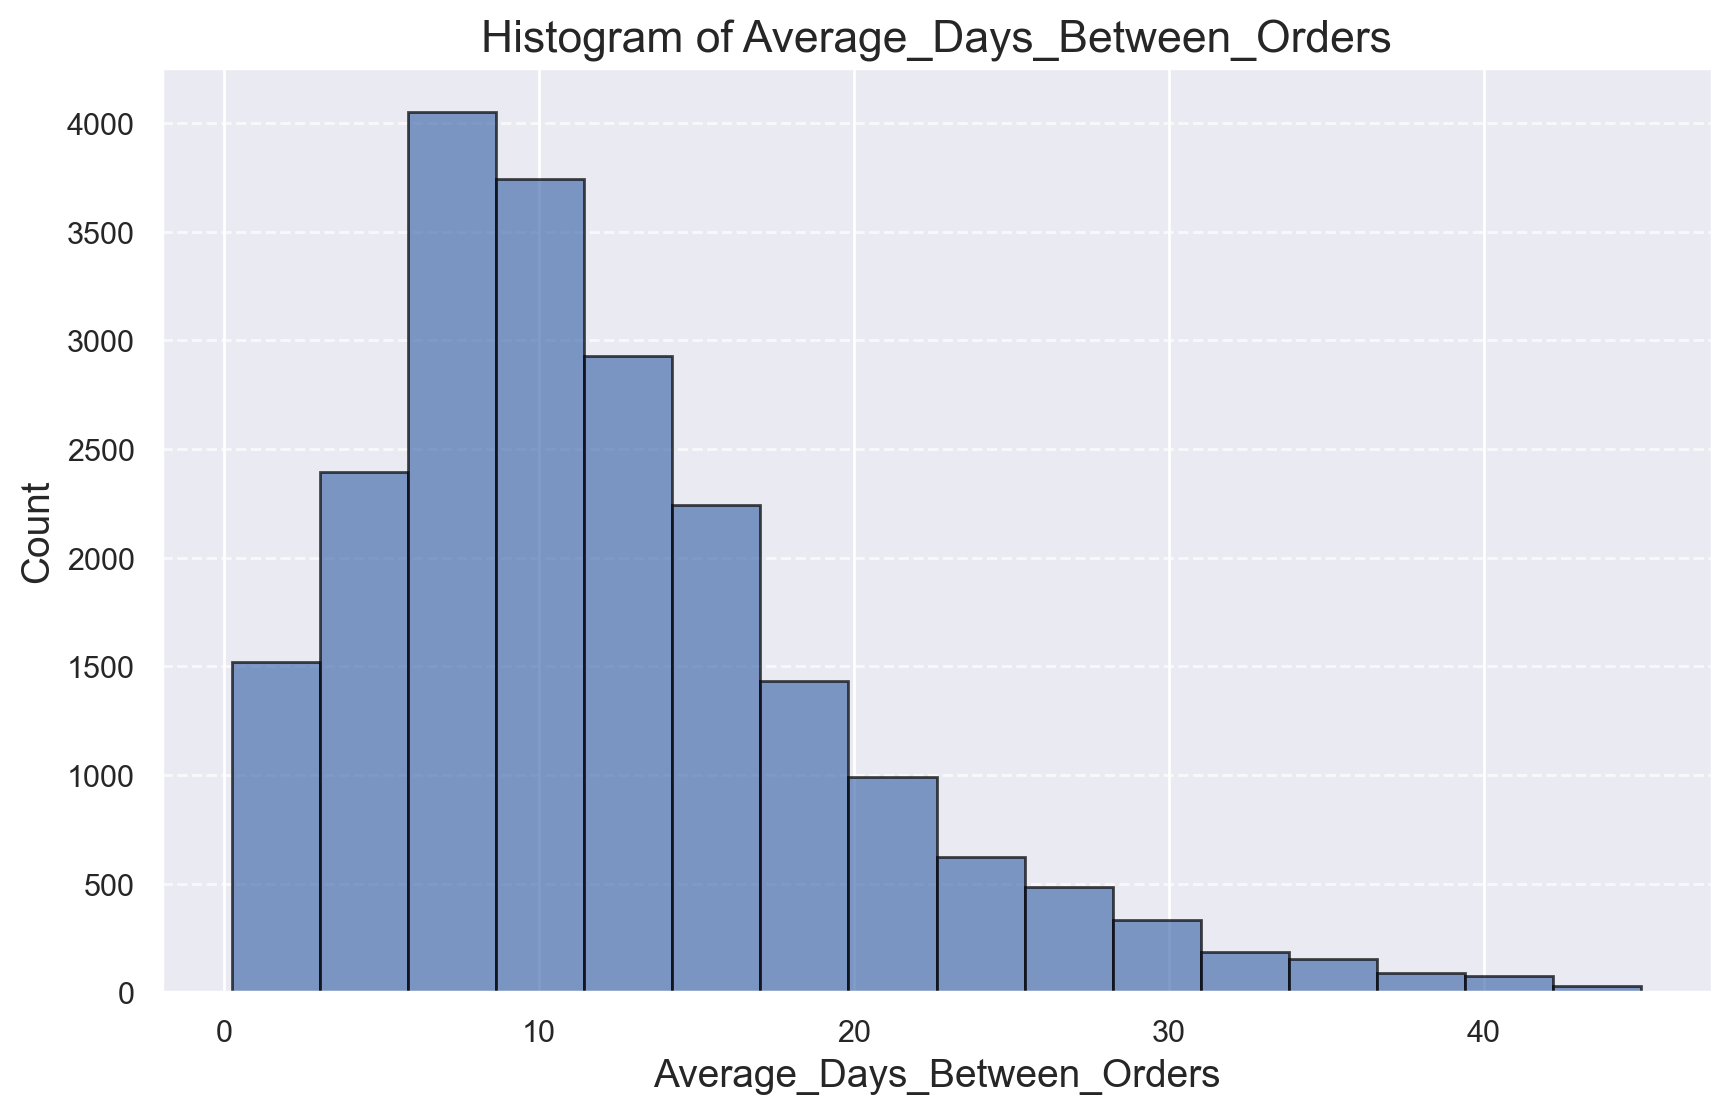

In [123]:
# Now plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(food_df['Average_Days_Between_Orders'], bins= number_bins_sturges(food_df['Average_Days_Between_Orders']), edgecolor='black', alpha=0.7)
plt.title('Histogram of Average_Days_Between_Orders', fontsize=16)
plt.xlabel('Average_Days_Between_Orders', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

    avg_spent_weekend & avg_spent_weekday

In [124]:
# Média de gasto em final de semana
food_df['avg_spent_weekend'] = food_df['total_spent'] / food_df['Weekend']

# Média de gasto em dias úteis
food_df['avg_spent_weekday'] = food_df['total_spent'] / food_df['Weekday']


In [125]:
food_df[(food_df['Weekend'] == 0 ) & (food_df['is_one_time_customer'] == 0)] # this values will go to infinte so we replace it by 0

customer_region  customer_age  vendor_count  product_count  \
customer_id                                                              
906b39f236             2000            33             3              4   
93c194cbfc             8000            23             2              3   
b31ffd3a42             8000            20             2              2   
c023baf684             2000            27             2              2   
4745a3c319             4000            27             2              6   
...                     ...           ...           ...            ...   
3828e3bc15             8000            21             2              2   
3da6b77b7c             8000            36             1              4   
960f26bb05             2000            23             2              3   
e581b0be3d             2000            29             2              2   
fd32223ed2             2000            23             1              2   

             first_order  last_order last_promo payment_method  CUI_Healthy  \
customer_id                                                                   
906b39f236             1          22    NOPROMO           CARD         0.00   
93c194cbfc             1          22    FREEBIE           CARD         0.00   
b31ffd3a42             1          22    FREEBIE           CARD         0.00   
c023baf684             1          22    NOPROMO           CARD         0.00   
4745a3c319             1          23    NOPROMO           CARD         0.00   
...                  ...         ...        ...            ...          ...   
3828e3bc15            81          88   DELIVERY           CASH         0.00   
3da6b77b7c            81          88    NOPROMO           CARD         0.00   
960f26bb05            81          88    FREEBIE           CARD        13.18   
e581b0be3d            81          88   DISCOUNT           CARD         0.00   
fd32223ed2            81          88   DELIVERY           CARD         0.00   

             CUI_OTHER  CUI_Street Food / Snacks  total_orders  midday_orders  \
customer_id                                                                     
906b39f236        4.02                       0.0             3              2   
93c194cbfc        0.00                       0.0             2              0   
b31ffd3a42        0.00                       0.0             2              1   
c023baf684        0.00                       0.0             2              2   
4745a3c319        0.00                       0.0             5              5   
...                ...                       ...           ...            ...   
3828e3bc15        0.00                       0.0             2              1   
3da6b77b7c        0.00                       0.0             2              2   
960f26bb05        0.00                       0.0             2              0   
e581b0be3d        0.00                       0.0             2              0   
fd32223ed2        0.00                       0.0             2              0   

             evening_orders  late_night_orders  Weekend  Weekday  \
customer_id                                                        
906b39f236                1                  0        0        3   
93c194cbfc                0                  2        0        2   
b31ffd3a42                0                  1        0        2   
c023baf684                0                  0        0        2   
4745a3c319                0                  0        0        5   
...                     ...                ...      ...      ...   
3828e3bc15                0                  1        0        2   
3da6b77b7c                0                  0        0        2   
960f26bb05                1                  2        0        2   
e581b0be3d                2                  0        0        2   
fd32223ed2                0                  2        0        2   

             Western_Cuisine  Asian_Cuisine  Desserts_Beverages  total_spent  \
cu

In [126]:
food_df[(food_df['Weekday'] == 0 ) & (food_df['is_one_time_customer'] == 0)] # this values will go to infinte so we replace it by 0

customer_region  customer_age  vendor_count  product_count  \
customer_id                                                              
c79709f885             4000            24             3              3   
986ffd3978             8000            23             2              2   
a9bac03d6b             4000            25             2              4   
cd9fbabc74             2000            25             1              3   
f05dc76d77             8000            22             3              6   
...                     ...           ...           ...            ...   
0e262ebb87             4000            35             1              3   
41e867f323             4000            26             2              2   
42cd4b717b             2000            53             2              2   
737fb4eaaa             4000            23             2              5   
d70866674d             4000            30             1              2   

             first_order  last_order last_promo payment_method  CUI_Healthy  \
customer_id                                                                   
c79709f885             0          19   DELIVERY           CARD          0.0   
986ffd3978             0          20    FREEBIE           CARD          0.0   
a9bac03d6b             0          20    NOPROMO           CARD          0.0   
cd9fbabc74             0          20    NOPROMO           DIGI          0.0   
f05dc76d77             0          20    FREEBIE           CARD          0.0   
...                  ...         ...        ...            ...          ...   
0e262ebb87            77          89   DISCOUNT           CARD          0.0   
41e867f323            77          89    NOPROMO           CARD          0.0   
42cd4b717b            77          89    NOPROMO           CARD          0.0   
737fb4eaaa            77          89    FREEBIE           CASH          0.0   
d70866674d            77          89    FREEBIE           CARD          0.0   

             CUI_OTHER  CUI_Street Food / Snacks  total_orders  midday_orders  \
customer_id                                                                     
c79709f885        3.82                       0.0             3              0   
986ffd3978        0.00                       0.0             2              2   
a9bac03d6b        0.00                       0.0             2              1   
cd9fbabc74        0.00                       0.0             2              0   
f05dc76d77        0.00                       0.0             3              1   
...                ...                       ...           ...            ...   
0e262ebb87        0.00                       0.0             2              2   
41e867f323        0.00                       0.0             2              1   
42cd4b717b        0.00                       0.0             2              1   
737fb4eaaa        0.00                       0.0             3              2   
d70866674d        0.00                       0.0             2              1   

             evening_orders  late_night_orders  Weekend  Weekday  \
customer_id                                                        
c79709f885                3                  0        3        0   
986ffd3978                0                  0        2        0   
a9bac03d6b                1                  0        2        0   
cd9fbabc74                2                  0        2        0   
f05dc76d77                0                  2        3        0   
...                     ...                ...      ...      ...   
0e262ebb87                0                  0        2        0   
41e867f323                1                  0        2        0   
42cd4b717b                1                  0        2        0   
737fb4eaaa                1                  0        3        0   
d70866674d                1                  0        2        0   

             Western_Cuisine  Asian_Cuisine  Desserts_Beverages  total_spent  \
cu

This values will go to infinte so we replace it by 0.

In [127]:
food_df = food_df.replace([np.inf, -np.inf], 0)

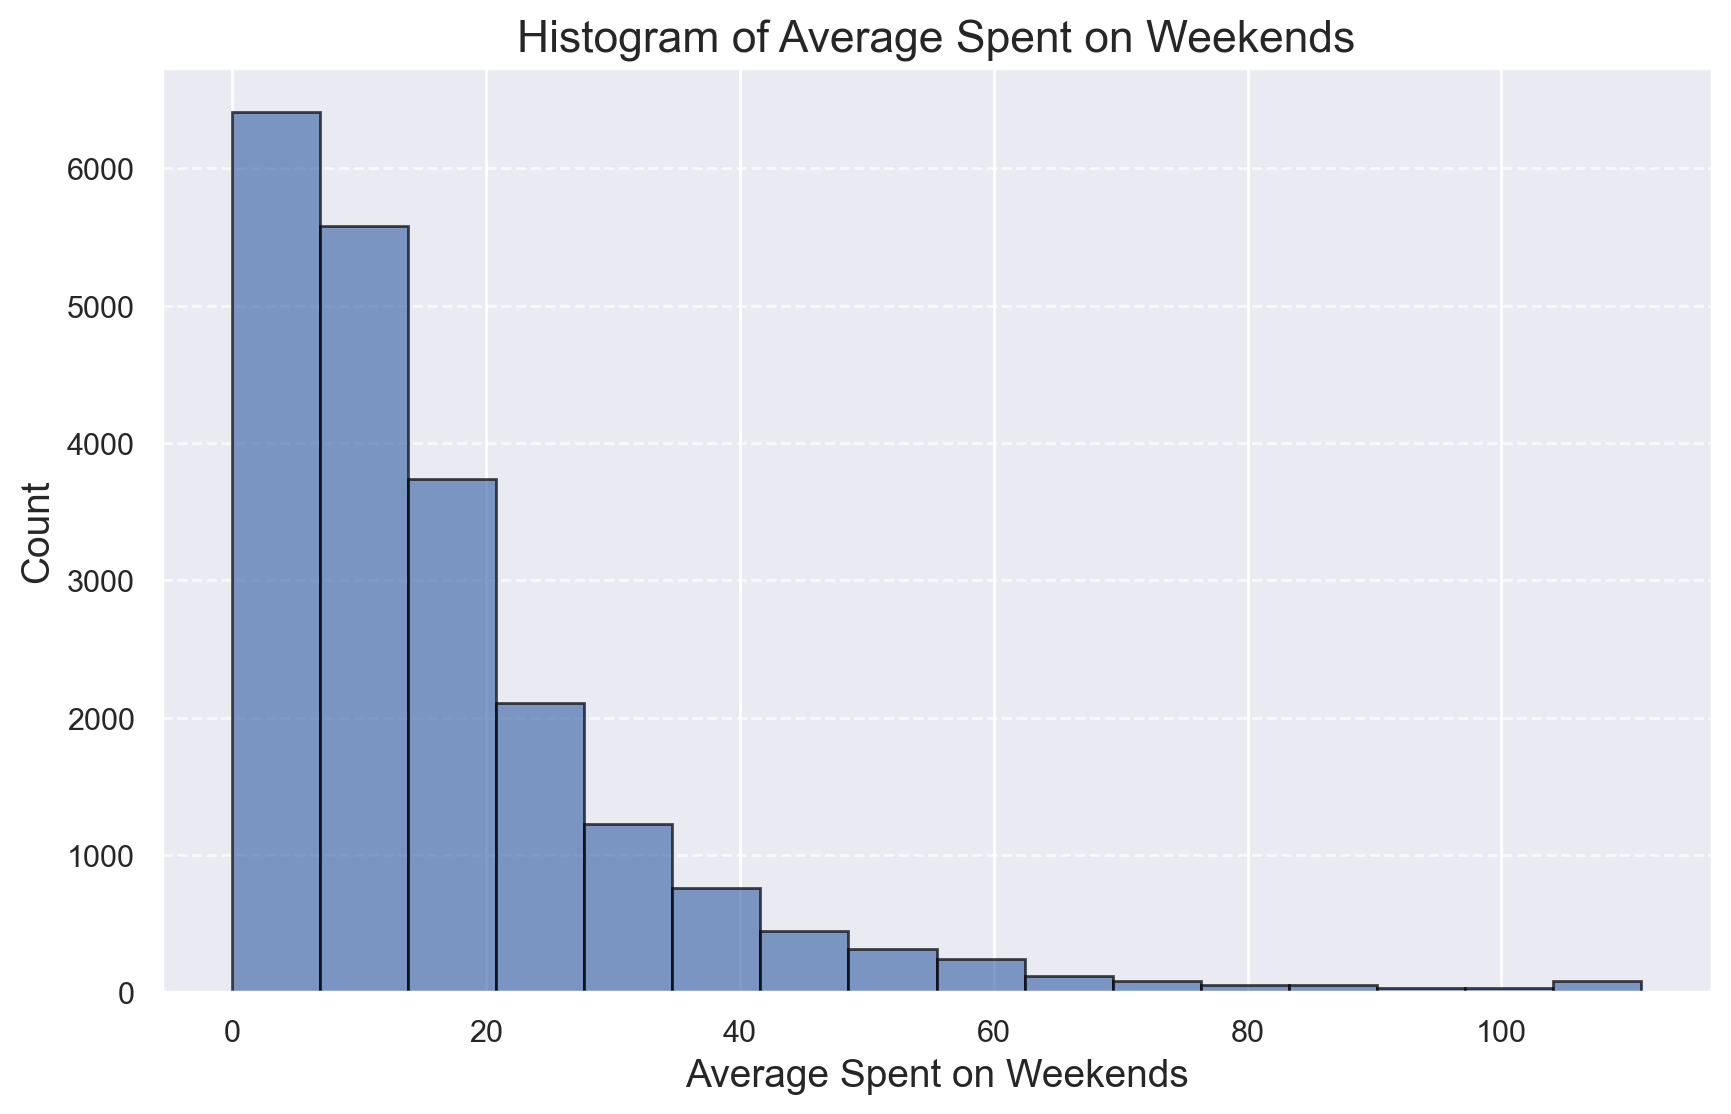

In [128]:
# Plot histogram for avg_spent_weekend
plt.figure(figsize=(10, 6))
plt.hist(food_df['avg_spent_weekend'], bins=number_bins_sturges(food_df['avg_spent_weekend']), edgecolor='black', alpha=0.7)
plt.title('Histogram of Average Spent on Weekends', fontsize=16)
plt.xlabel('Average Spent on Weekends', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

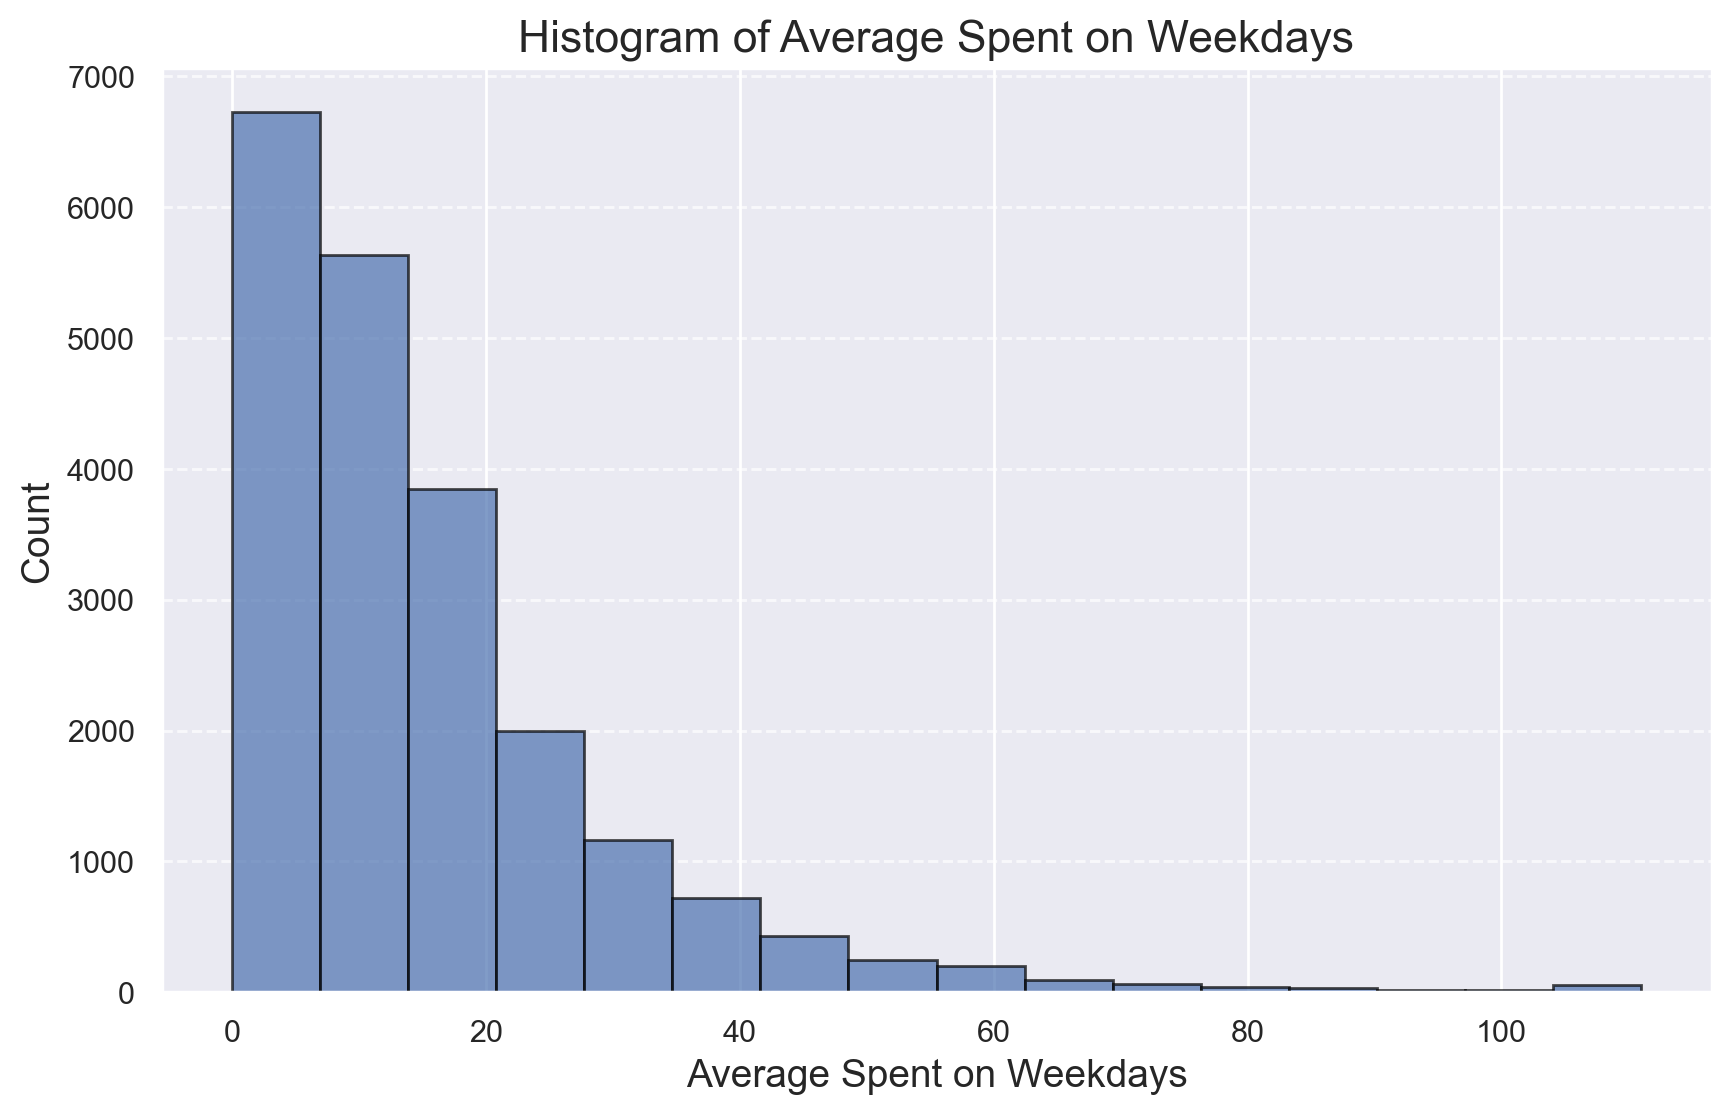

In [129]:
# Plot histogram for avg_spent_weekday
plt.figure(figsize=(10, 6))
plt.hist(food_df['avg_spent_weekday'], bins=number_bins_sturges(food_df['avg_spent_weekday']), edgecolor='black', alpha=0.7)
plt.title('Histogram of Average Spent on Weekdays', fontsize=16)
plt.xlabel('Average Spent on Weekdays', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

    avg_spent_midday & avg_spent_evening & avg_spent_late_night

In [130]:
# Calcular a média de gasto para cada período do dia
food_df['avg_spent_midday'] = food_df['total_spent'] / food_df['midday_orders']
food_df['avg_spent_evening'] = food_df['total_spent'] / food_df['evening_orders']
food_df['avg_spent_late_night'] = food_df['total_spent'] / food_df['late_night_orders']

# Tratando divisões por zero ou valores infinitos
food_df = food_df.replace([np.inf, -np.inf], 0)


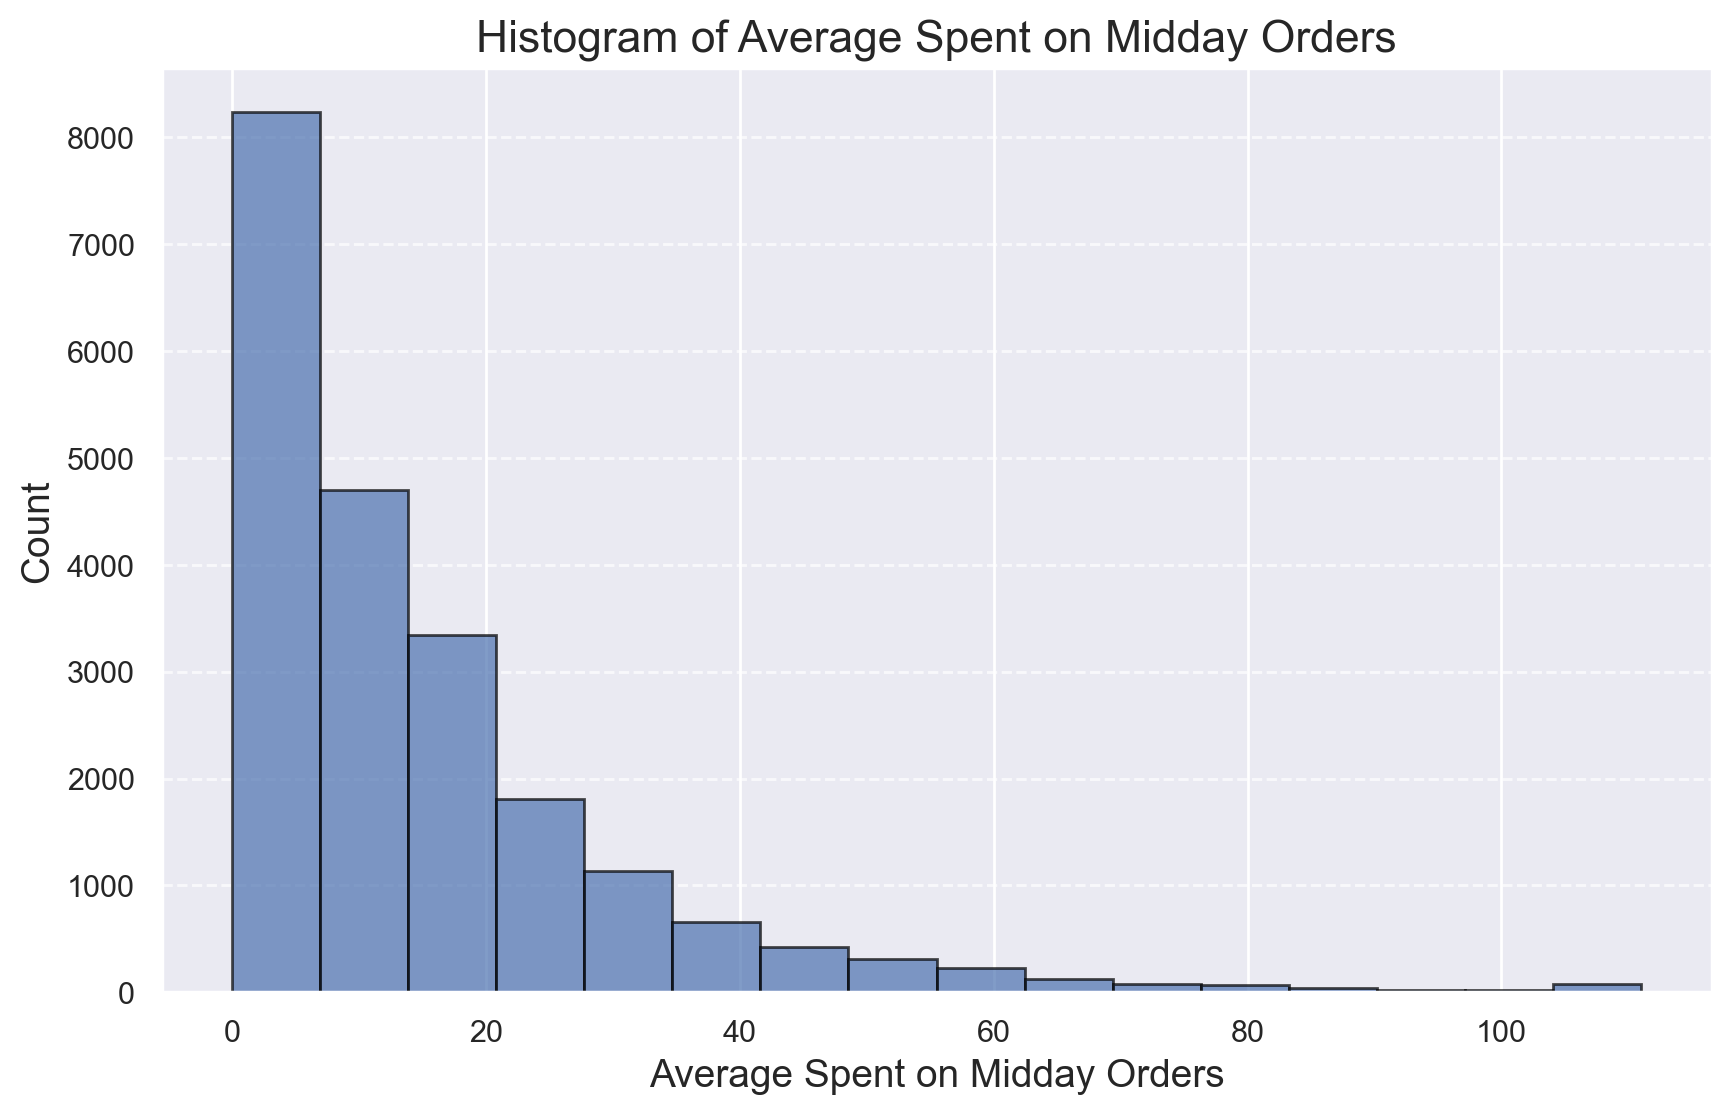

In [131]:
# Plot histogram for avg_spent_midday
plt.figure(figsize=(10, 6))
plt.hist(food_df['avg_spent_midday'], bins=number_bins_sturges(food_df['avg_spent_midday']), edgecolor='black', alpha=0.7)
plt.title('Histogram of Average Spent on Midday Orders', fontsize=16)
plt.xlabel('Average Spent on Midday Orders', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

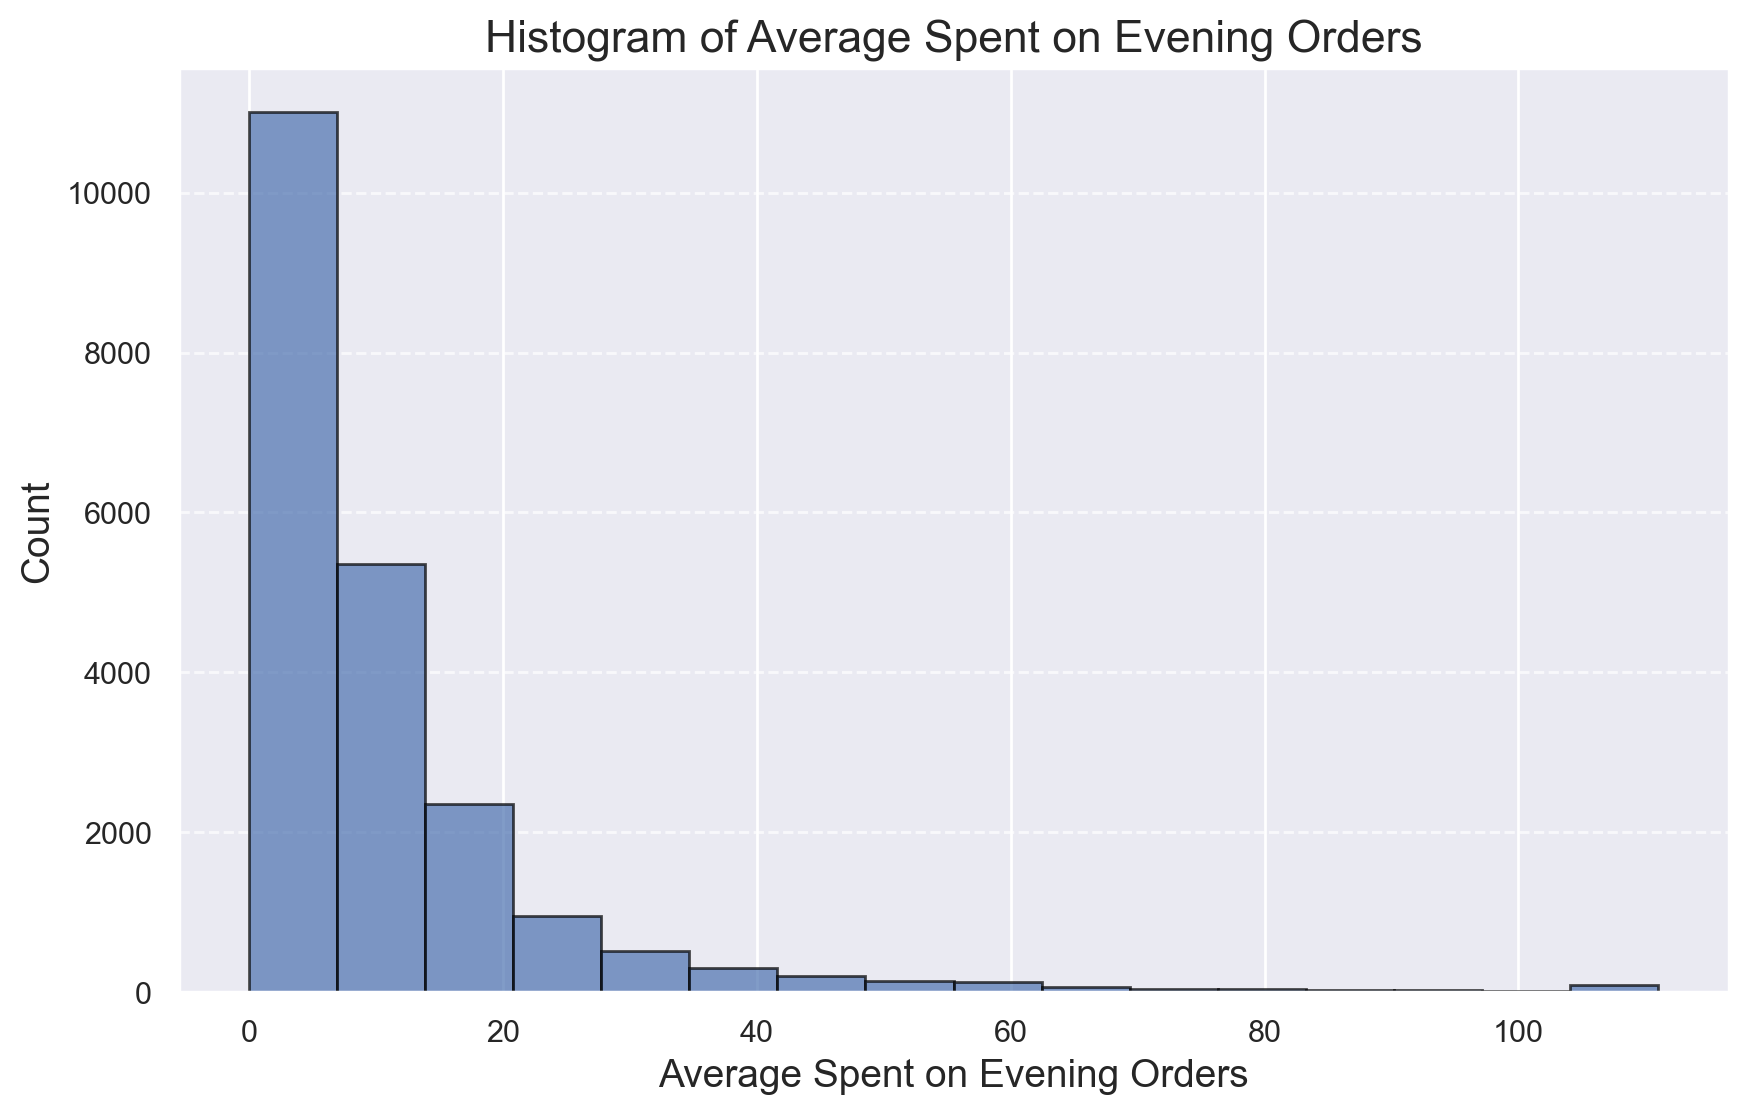

In [132]:
# Plot histogram for avg_spent_evening
plt.figure(figsize=(10, 6))
plt.hist(food_df['avg_spent_evening'], bins=number_bins_sturges(food_df['avg_spent_evening']), edgecolor='black', alpha=0.7)
plt.title('Histogram of Average Spent on Evening Orders', fontsize=16)
plt.xlabel('Average Spent on Evening Orders', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

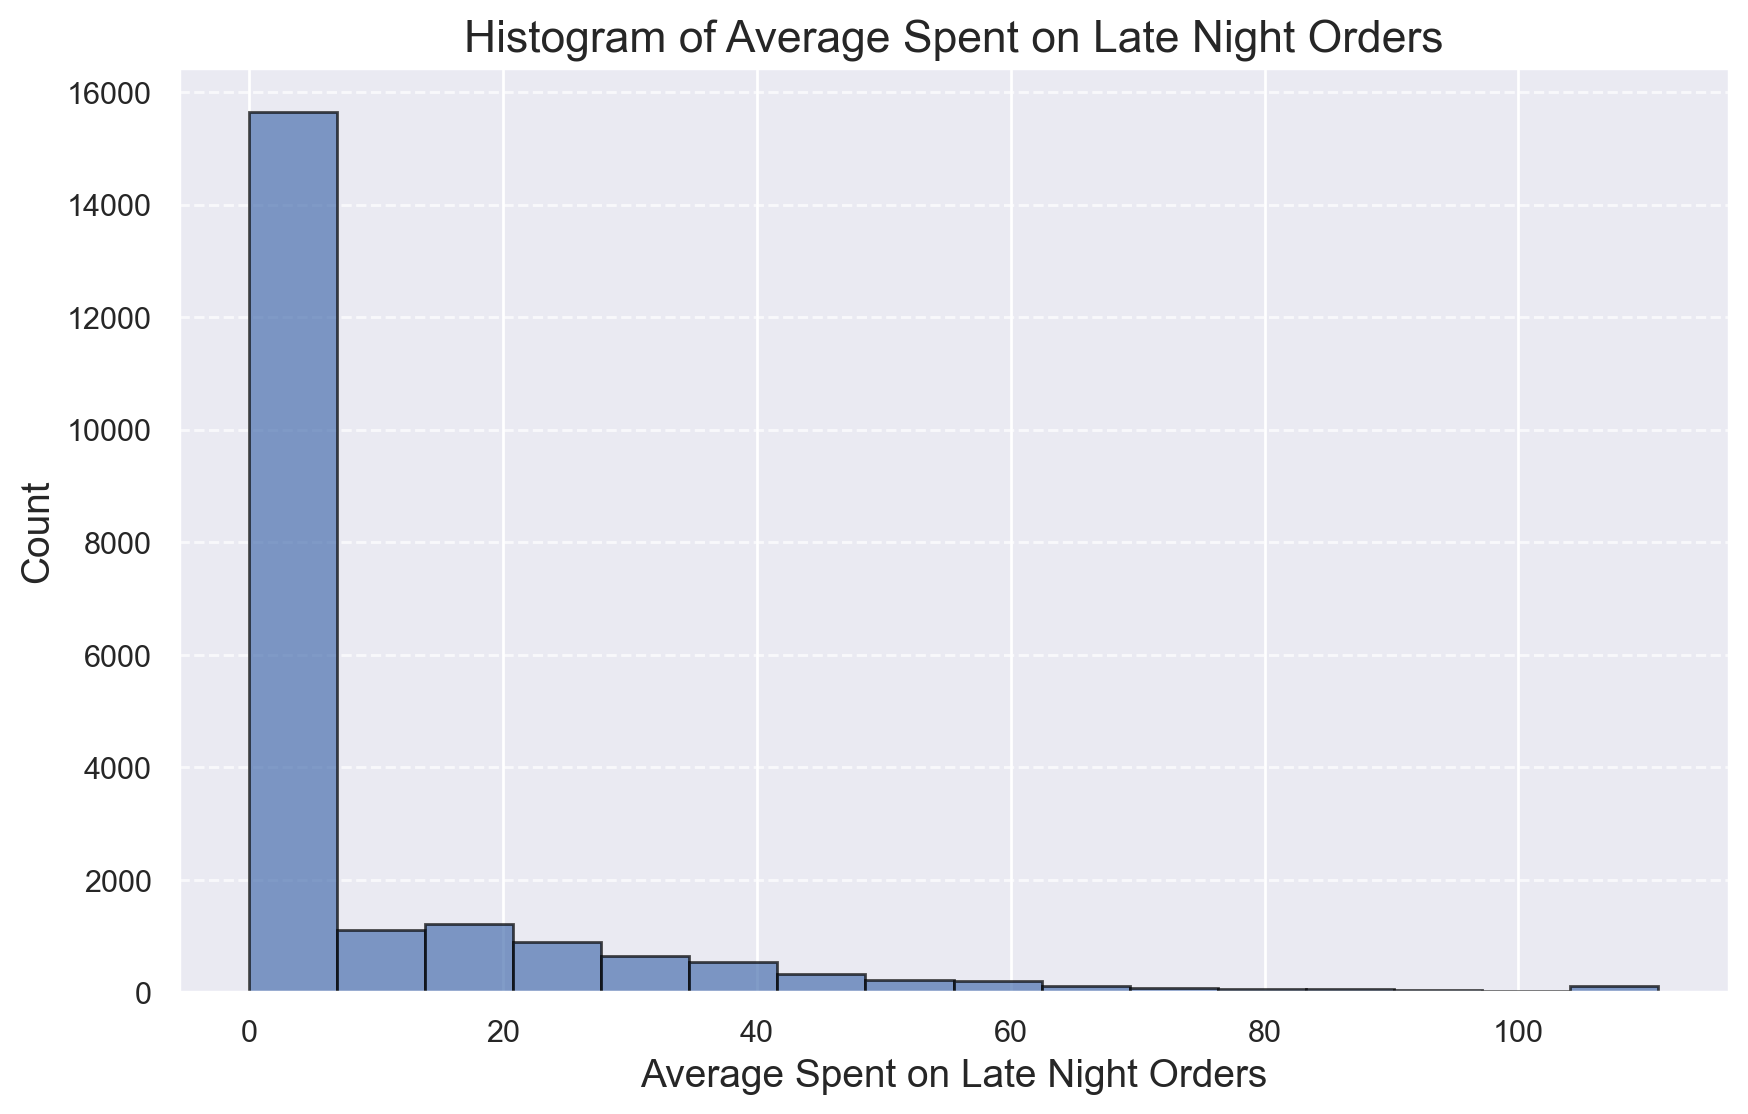

In [133]:
# Plot histogram for avg_spent_late_night
plt.figure(figsize=(10, 6))
plt.hist(food_df['avg_spent_late_night'], bins=number_bins_sturges(food_df['avg_spent_late_night']), edgecolor='black', alpha=0.7)
plt.title('Histogram of Average Spent on Late Night Orders', fontsize=16)
plt.xlabel('Average Spent on Late Night Orders', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [134]:
food_df.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'first_order', 'last_order', 'last_promo', 'payment_method',
       'CUI_Healthy', 'CUI_OTHER', 'CUI_Street Food / Snacks', 'total_orders',
       'midday_orders', 'evening_orders', 'late_night_orders', 'Weekend',
       'Weekday', 'Western_Cuisine', 'Asian_Cuisine', 'Desserts_Beverages',
       'total_spent', 'Average Spent per Order', 'Customer_Lifetime',
       'is_one_time_customer', 'chain_category', 'Average_Days_Between_Orders',
       'avg_spent_weekend', 'avg_spent_weekday', 'avg_spent_midday',
       'avg_spent_evening', 'avg_spent_late_night'],
      dtype='object')

## 6. Feature Selection

In [135]:
food_categorical = food_df.select_dtypes(include="object")
food_categorical = food_categorical.join(food_df['is_one_time_customer'])

In [136]:
food_numerical = food_df.select_dtypes(exclude="object") 
food_numerical = food_numerical.drop(columns='is_one_time_customer')

**Cramer'V for categroical features**

In [137]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

In [138]:
cramers_df=food_categorical.drop(columns='chain_category')
results_cramer = pd.DataFrame(index=cramers_df.columns, columns=cramers_df.columns)

for var1 in cramers_df.columns:
    for var2 in cramers_df.columns:
        if var1 != var2:
            results_cramer.loc[var1, var2] = cramers_v(cramers_df[var1],food_df[var2])
        else:
            results_cramer.loc[var1, var2] = 1  #perfect association with itself

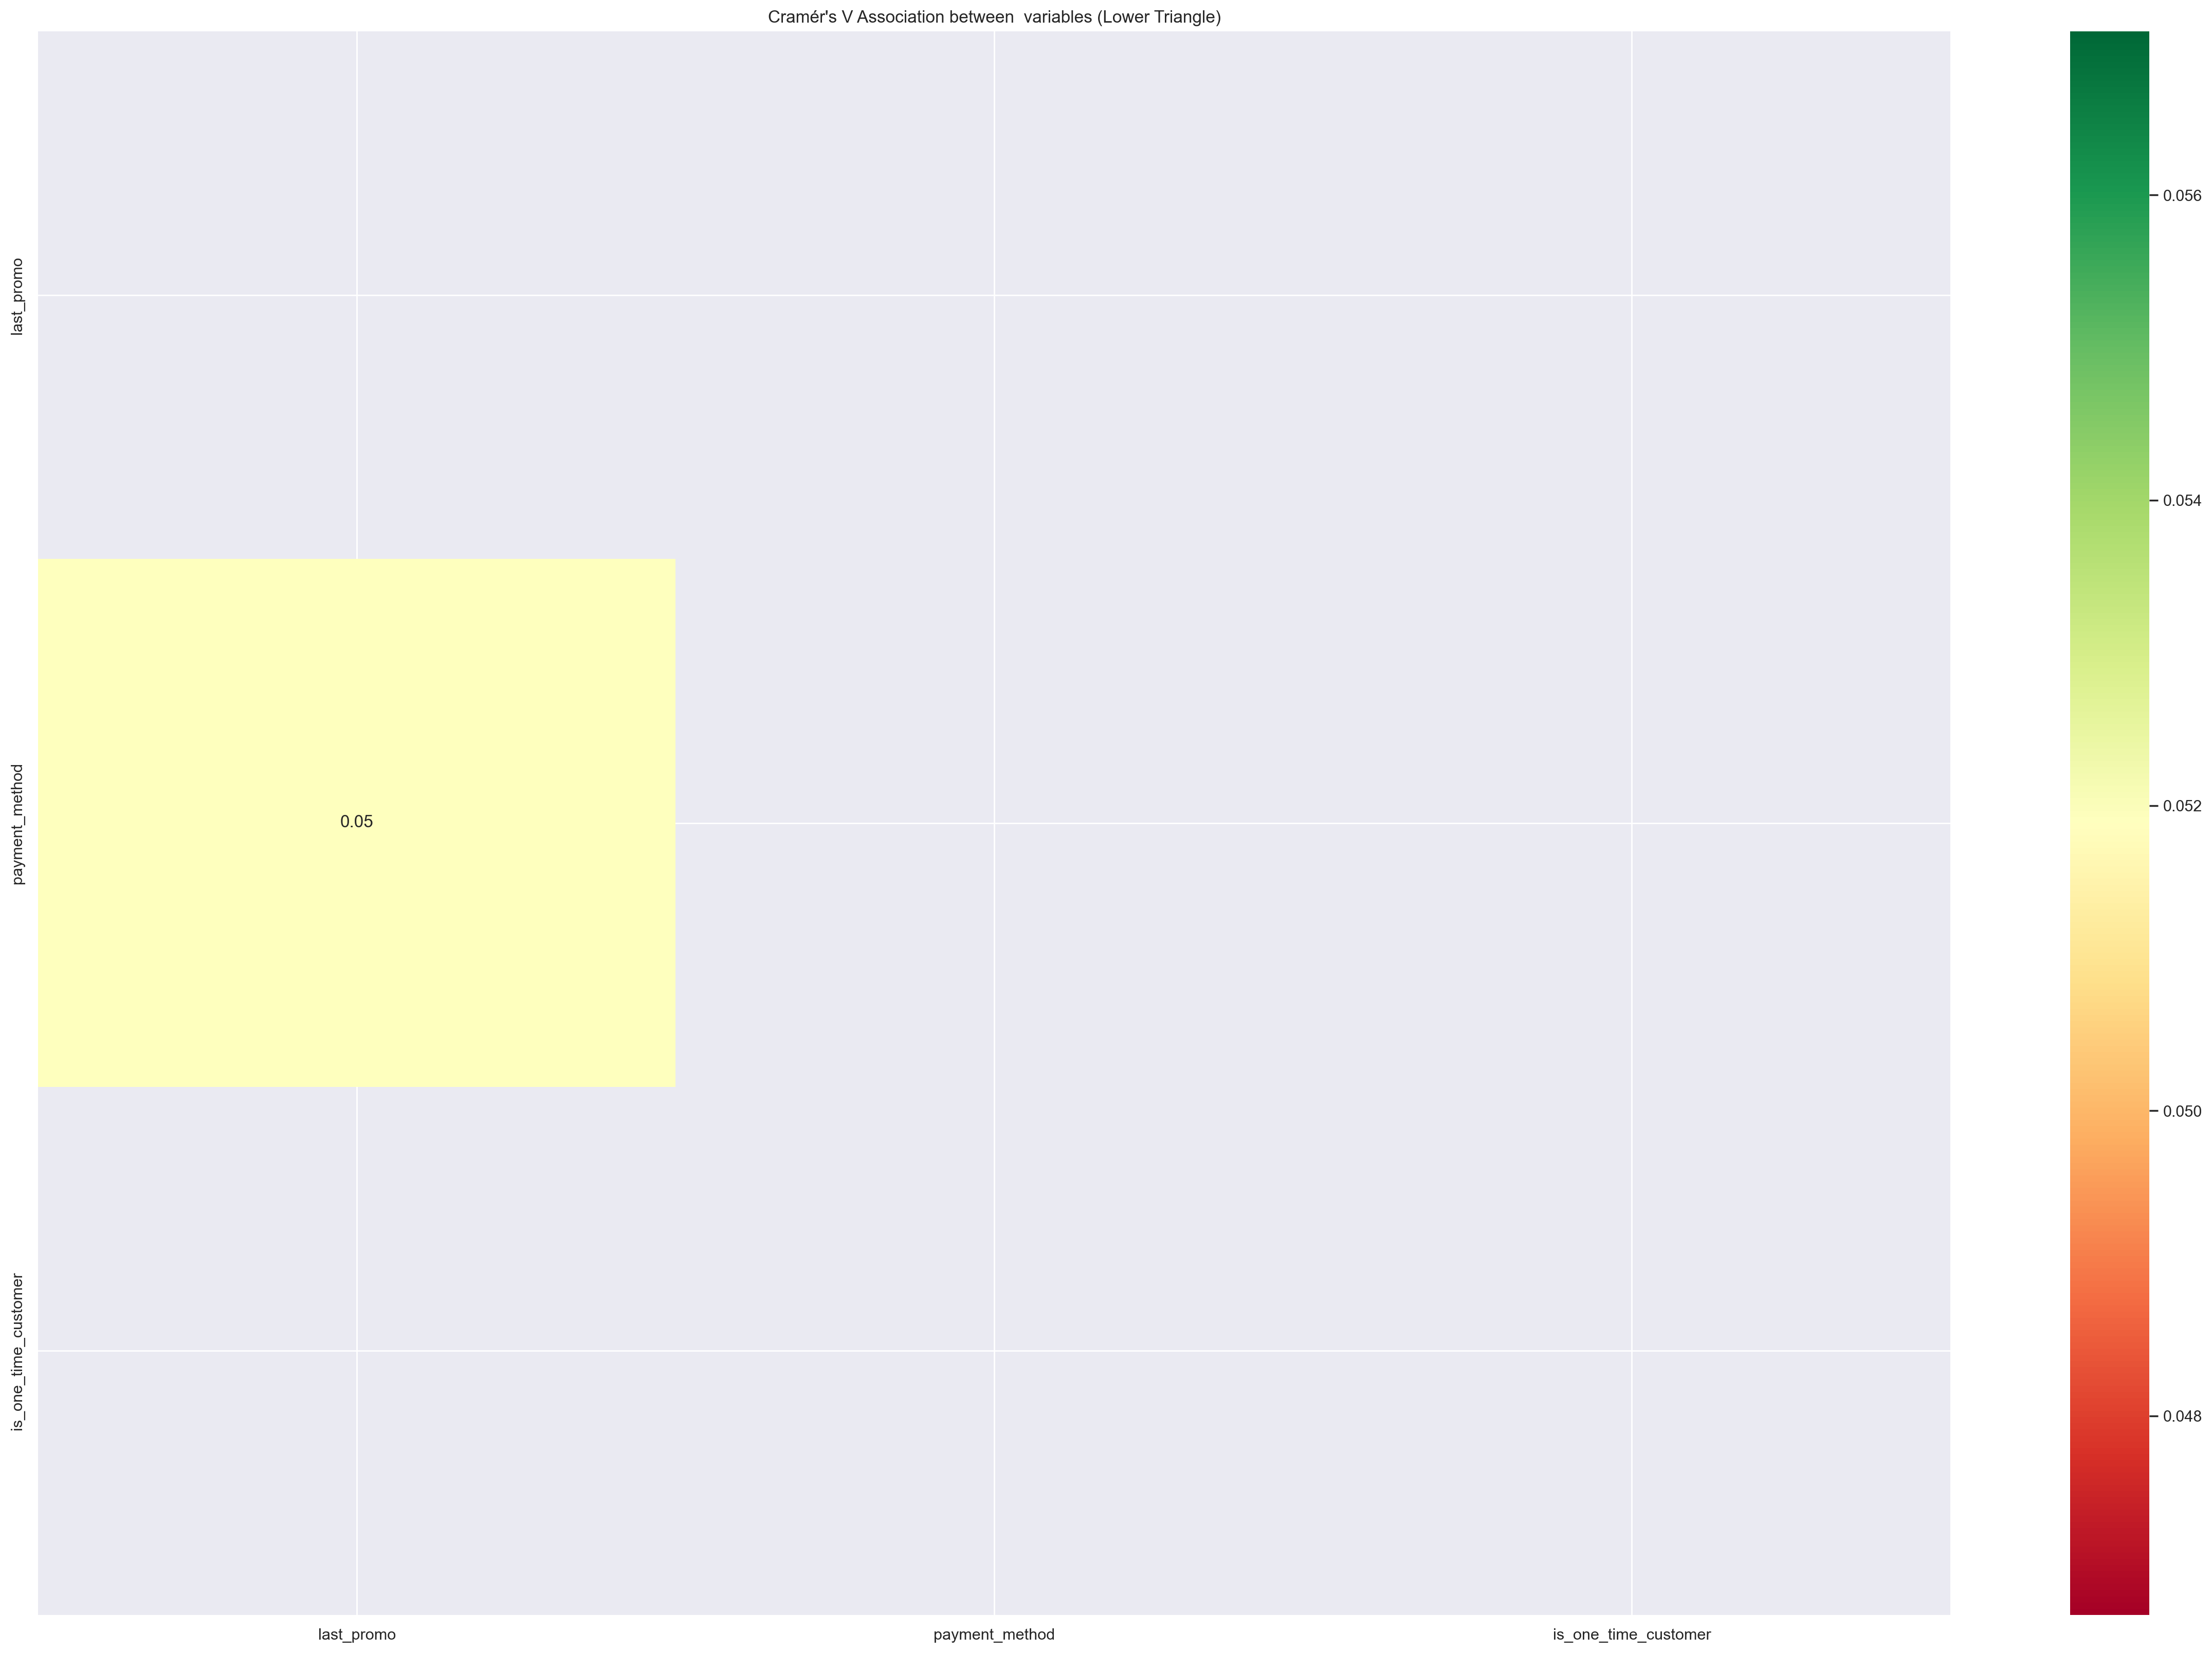

In [139]:
#Heatmap of Cramér's V
results_cramer = results_cramer.astype(float)
mask = np.triu(np.ones_like(results_cramer, dtype=bool))
plt.figure(figsize=(30, 20))
sns.heatmap(results_cramer, annot=True, cmap="RdYlGn", cbar=True, mask=mask, fmt='.2f', linewidths=0, linecolor='white')
plt.title("Cramér's V Association between  variables (Lower Triangle)")
plt.show()

>Cohen's interpretation (1988) — "Cramér's V: 
- <0.1 Negligible, 
- 0.1-0.3 Small, 
- 0.3-0.5 Medium, 
- and >0.5 Large

    last promo vs one_time_customer
- Indicates a very weak association between the last promotion and whether a customer is a one-time customer(0.06). This implies that the last promotion may not have much effect on whether the customer only made a single purchase.


    last promo vs payment method
- This suggests that there might be a small influence of promotional offers on the payment method choice(association of 0.09), but the relationship is very weak.

    is_one_time_customer vs payment method/last_promo
-  0.25 of association, indicating that the payment method may slightly influence wether the customer is a one time customer of not, but it is still a very small association

**Spearman Correlation for Numerical features**

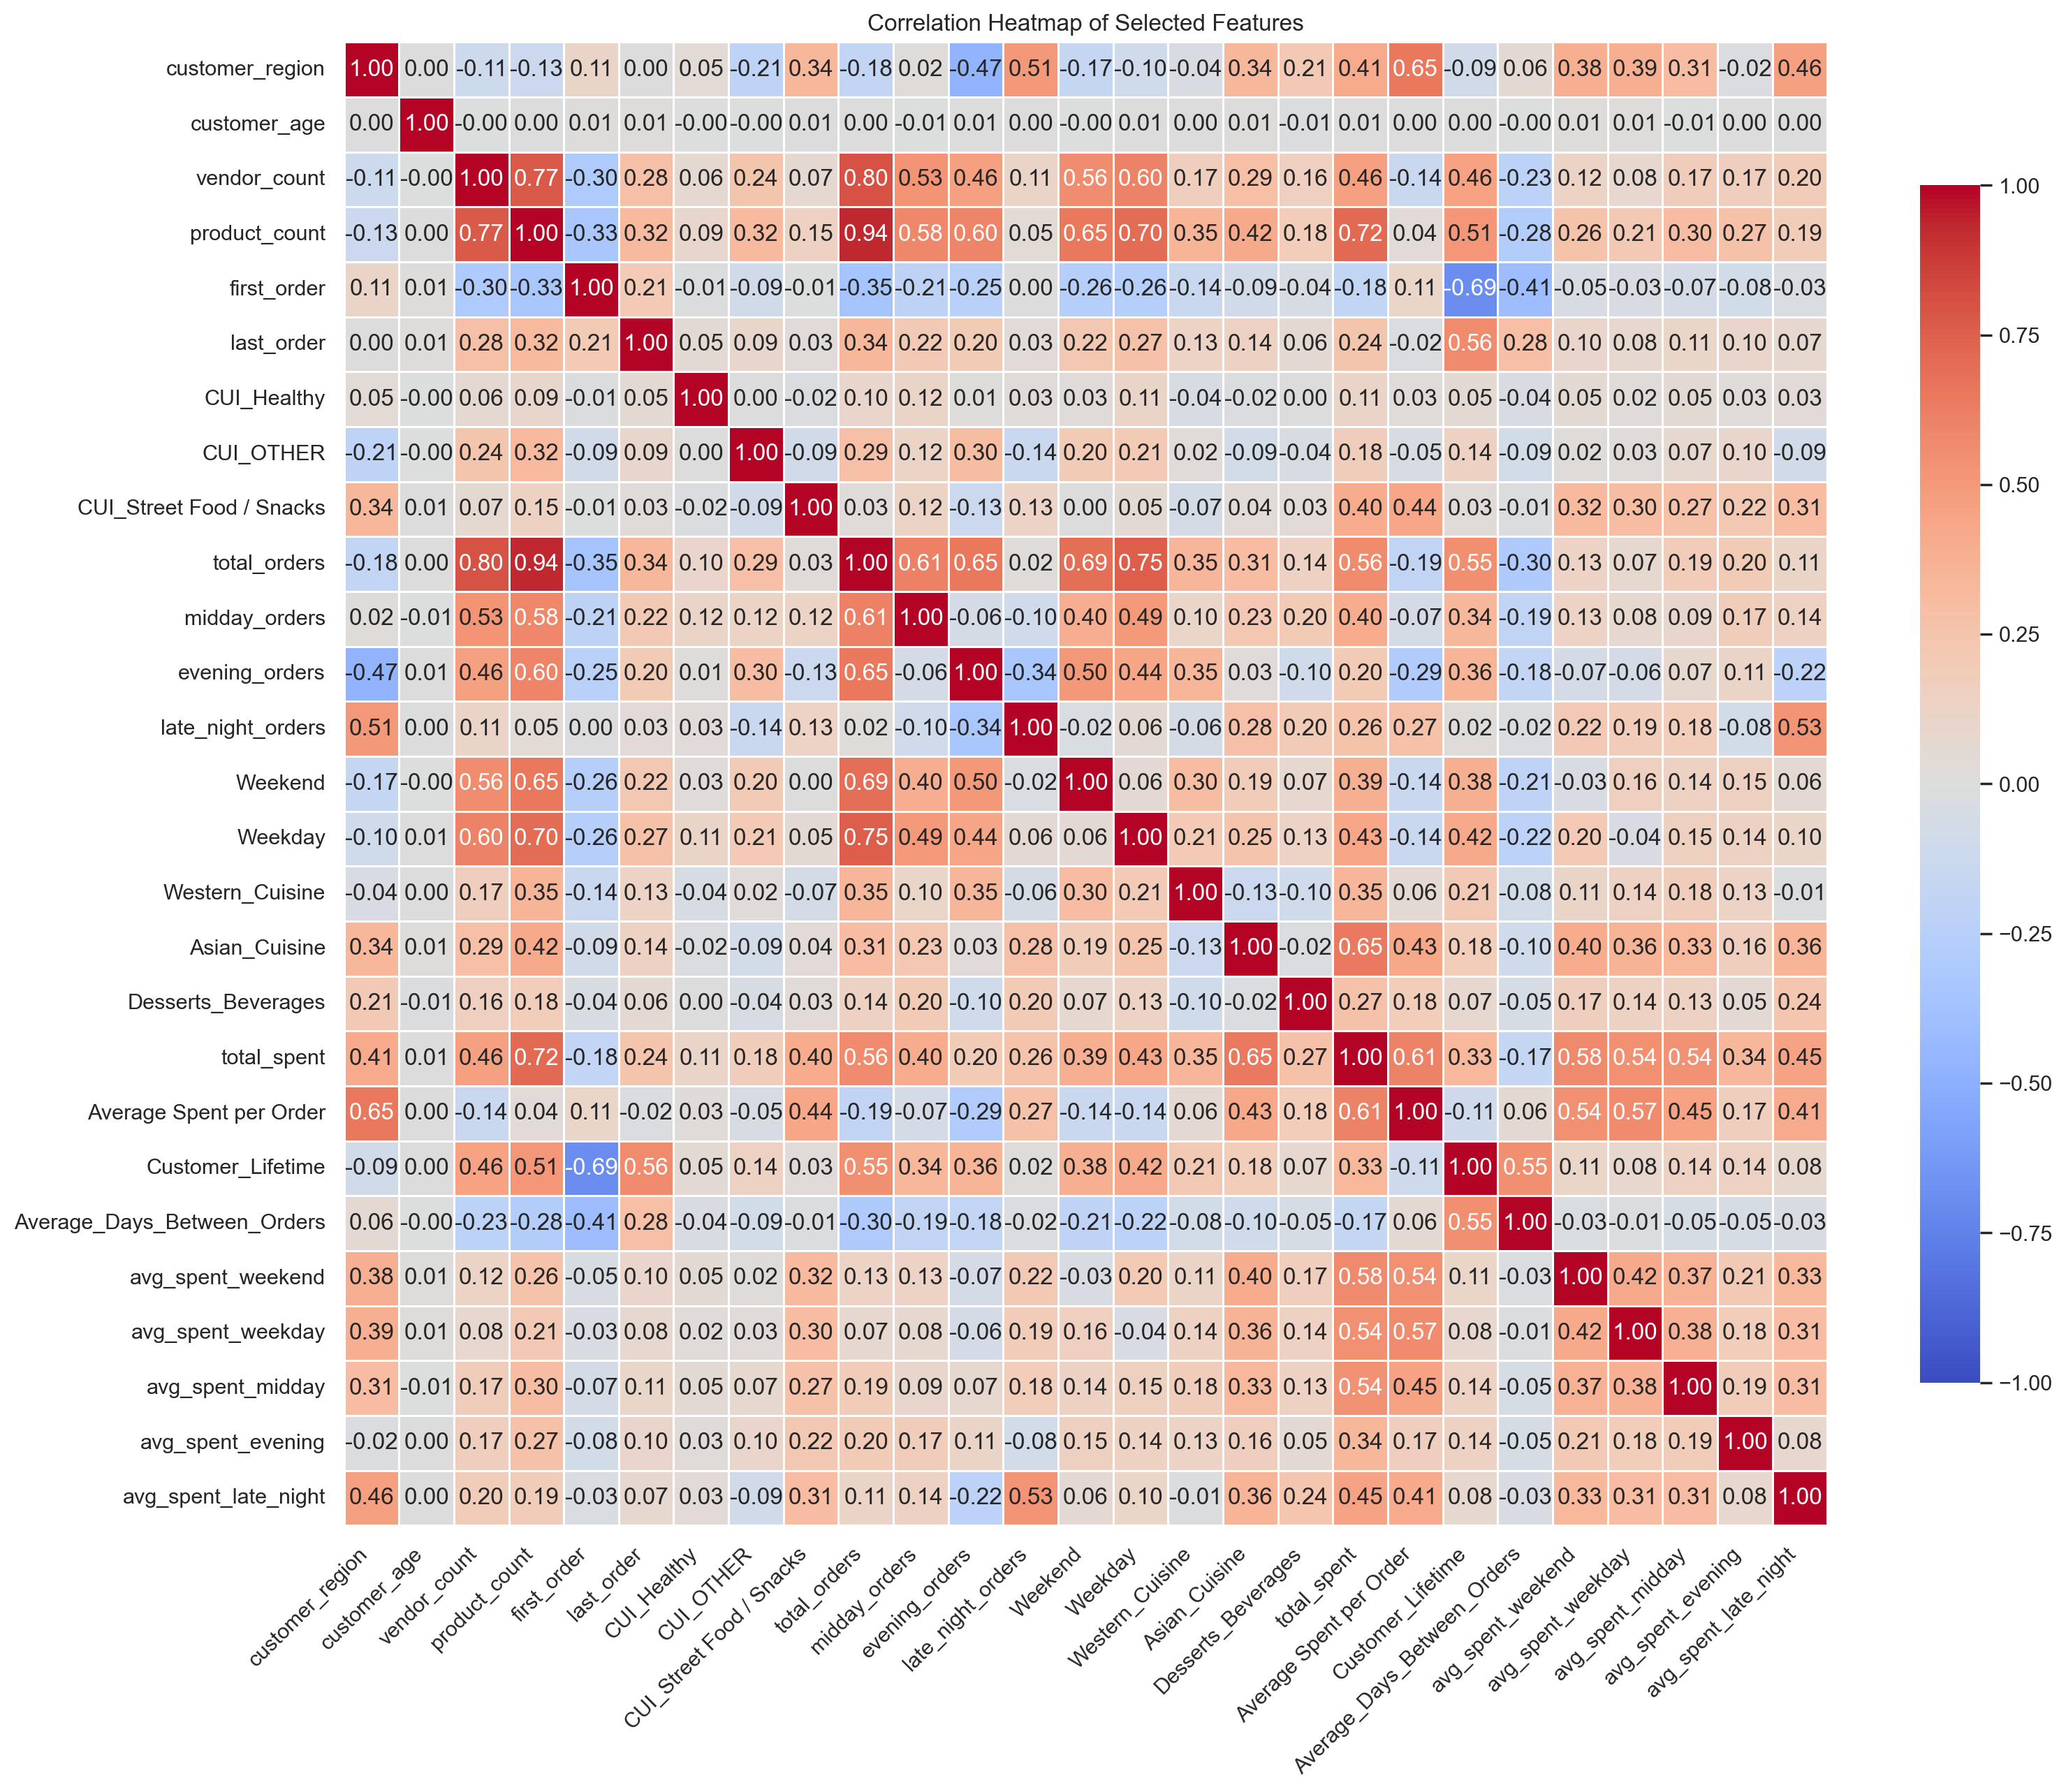

In [140]:
# Calculating the correlation matrix for the selected features
correlation_matrix = food_numerical.corr()

# Creating the heatmap
plt.figure(figsize=(16, 13))
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation coefficients
            fmt='.2f',   # Format for the annotation
            cmap='coolwarm',  # Color map
            square=True,  # Make cells square
            cbar_kws={"shrink": .8},  # Color bar size
            linewidths=0.5,  # Lines between cells
            vmin=-1,  # Minimum limit for color bar
            vmax=1)  # Maximum limit for color bar

# Set titles and labels
plt.title('Correlation Heatmap of Selected Features')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for readability
plt.yticks(rotation=0)  # Keep y labels horizontal
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

>Rule of thumb from Rea and Parker (2014) — "Correlation values: 
- 0-0.1 Negligible, 
- 0.1-0.2 Weak, 
- 0.2-0.4 Moderate, 
- 0.4-0.6 Relatively Strong, 
- 0.6-0.8 Strong, 
- and >=0.8 Very Strong"
We selected only the columns with very strong Correlation.

- Total orders and Product count seem to have a very high correlation(0.94), which tell us that the columns may be giving us the same information, hence, we are going to drop product count.
- Vendor count also presents a high correlatin wih the columns total orders(0.84) and product count(0.80), hence we may also consider dropping this column.
- Customer age seems to have no relevant correlation with any of the features
- Weekday also has a high correlatino with total orders(0.80)

In [796]:
show_missing(food_df)

variable    dtype  count  unique  missing  pc_missing
0               customer_region    int64  28029       3        0           0
1                  customer_age    int64  28029      66        0           0
2                  vendor_count    int64  28029       9        0           0
3                 product_count    int64  28029      15        0           0
4                   first_order    int64  28029      91        0           0
5                    last_order    int64  28029      91        0           0
6                    last_promo   object  28029       4        0           0
7                payment_method   object  28029       3        0           0
8                   CUI_Healthy  float64  28029     987        0           0
9                     CUI_OTHER  float64  28029    2184        0           0
10     CUI_Street Food / Snacks  float64  28029    2046        0           0
11                 total_orders    int64  28029      10        0           0
12                midday_orders    int64  28029       6        0           0
13               evening_orders    int64  28029       6        0           0
14            late_night_orders    int64  28029       4        0           0
15                      Weekend    int64  28029       7        0           0
16                      Weekday    int64  28029       7        0           0
17              Western_Cuisine  float64  28029    3851        0           0
18                Asian_Cuisine  float64  28029    5261        0           0
19           Desserts_Beverages  float64  28029    2389        0           0
20                  total_spent  float64  28029    8753        0           0
21      Average Spent per Order  float64  28029    3189        0           0
22            Customer_Lifetime    int64  28029      91        0           0
23         is_one_time_customer    int32  28029       2        0           0
24               chain_category   object  28029       6       81           0
25  Average_Days_Between_Orders  float64  28029     468        0           0
26            avg_spent_weekend  float64  28029   10420        0           0
27            avg_spent_weekday  float64  28029   10611        0           0
28             avg_spent_midday  float64  28029    9777        0           0
29            avg_spent_evening  float64  28029    9020        0           0
30         avg_spent_late_night  float64  28029    4711        0           0

In [797]:
food_numerical.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'first_order', 'last_order', 'CUI_Healthy', 'CUI_OTHER',
       'CUI_Street Food / Snacks', 'total_orders', 'midday_orders',
       'evening_orders', 'late_night_orders', 'Weekend', 'Weekday',
       'Western_Cuisine', 'Asian_Cuisine', 'Desserts_Beverages', 'total_spent',
       'Average Spent per Order', 'Customer_Lifetime',
       'Average_Days_Between_Orders', 'avg_spent_weekend', 'avg_spent_weekday',
       'avg_spent_midday', 'avg_spent_evening', 'avg_spent_late_night'],
      dtype='object')

In [798]:
#TODO Não vamos dropar vendor count?
food_df = food_df.drop(columns=['product_count','Weekday'])

In [799]:
food_numerical.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'first_order', 'last_order', 'CUI_Healthy', 'CUI_OTHER',
       'CUI_Street Food / Snacks', 'total_orders', 'midday_orders',
       'evening_orders', 'late_night_orders', 'Weekend', 'Weekday',
       'Western_Cuisine', 'Asian_Cuisine', 'Desserts_Beverages', 'total_spent',
       'Average Spent per Order', 'Customer_Lifetime',
       'Average_Days_Between_Orders', 'avg_spent_weekend', 'avg_spent_weekday',
       'avg_spent_midday', 'avg_spent_evening', 'avg_spent_late_night'],
      dtype='object')

# Data Exporting

In [800]:
food_df.to_csv('food_df_scaled.csv', index=True)
